# SISR Workshop

In [1]:
# Own imports
from Config.Config import Path, CurrentDevice
from Dataset.Dataset_UE import Dataset_UE, load_exr_file, save_exr
from Utils.Utils import save_model, load_model
from Training_Pipeline import training_pipeline

C:\Users\andry\Anaconda3\envs\pytorch_env\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# Initialize config
import DefaultConfigs as dc
from importlib import reload

C:\Users\andry\Anaconda3\envs\pytorch_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\andry\Anaconda3\envs\pytorch_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
# Initialize config
def initConfig() -> dc.ConfigMapping:
    reload(dc)
    config = dc.ConfigMapping(dc.CoreDict)
    config["hyperparameters"] = dc.HyperparametersDict
    config["trainDS"] = dc.TrainDatasetDict
    config["validDS"] = dc.ValidDatasetDict
    config["trainDL"] = dc.TrainDataloaderDict
    config["validDL"] = dc.ValidDataloaderDict
    config["model"] = dc.ModelDict
    config["criterion"] = dc.CriterionDict
    config["optimizer"] = dc.OptimizerDict
    return config

In [4]:
config = initConfig()
print(config)

run_training:                 True 
load_model:                   False 
device:                       cuda:0 
dtype:                        torch.float32 
model_save_path:              F:\MASTERS\Upscaler\Results\2023-04-24\Trainings\Model_NoCheckerboard\Epochs_600_1_2_VGG600epochs_baseline_noBNL1VGG 
model_load_path:              F:\MASTERS\Upscaler\Results\2023-04-24\Trainings\Model_NoCheckerboard\Epochs_600_1_2_VGG600epochs_baseline_noBNL1VGG 
model_inference_path:         F:\MASTERS\Upscaler\Results\2023-04-24\Inference\Model_NoCheckerboard\Epochs_600_1_2_VGG600epochs_baseline_noBNL1VGG 
cached_ds:                    False 
hyperparameters 
  ClassName:                  ModelHyperparameters 
  in_channels:                3 
  out_channels:               3 
  learning_rate:              0.0001 
  batch_size:                 32 
  num_epochs:                 600 
trainDS 
  ClassName:                  FullDataset_UE 
  name:                       FullDataset_UE 
  ds_root_path:     

In [5]:
import torch

In [6]:
from Colorspace.PreProcessing import tonemap_reinhard
from typing import Tuple
import matplotlib.pyplot as plt
import numpy as np

def show_tensor(tens:torch.tensor=None, exposure:float=1.0, figsize:Tuple[int, int]=(20,20)):
    assert tens is not None, "show_tensor function requires tensor != None"
    
    tens = tens.float() * exposure
    tens = tonemap_reinhard(tens)
    npimg = tens.detach().numpy()
    
    plt.figure(figsize=figsize)    
    plt.imshow(np.transpose(npimg, (1,2,0)))
    
    
def show_tensor_channels(tens:torch.tensor=None, num_channels:int=2, x_dim:int=2, y_dim:int=2):
    assert tens is not None, "show_tensor function requires tensor != None"
    colors = ['rainbow', 'PuRd_r', 'gist_earth', 'coolwarm']
    np_tens = tens.detach().numpy()
    for i in range(num_channels):
        plt.subplot(x_dim, y_dim, i+1)
        plt.imshow(np_tens[i,:,:])# cmap=colors[i])
    plt.show()

In [7]:
#CHW Format
tens = load_exr_file("F:/MASTERS/UE4/DATASET/InfiltratorDemo_4_26_2/DumpedBuffers/1920x1080-native/SceneColor/88.exr").float()
#NCHW Format
b_tens = tens.unsqueeze(0) 

In [8]:
tens.shape

torch.Size([3, 1080, 1920])

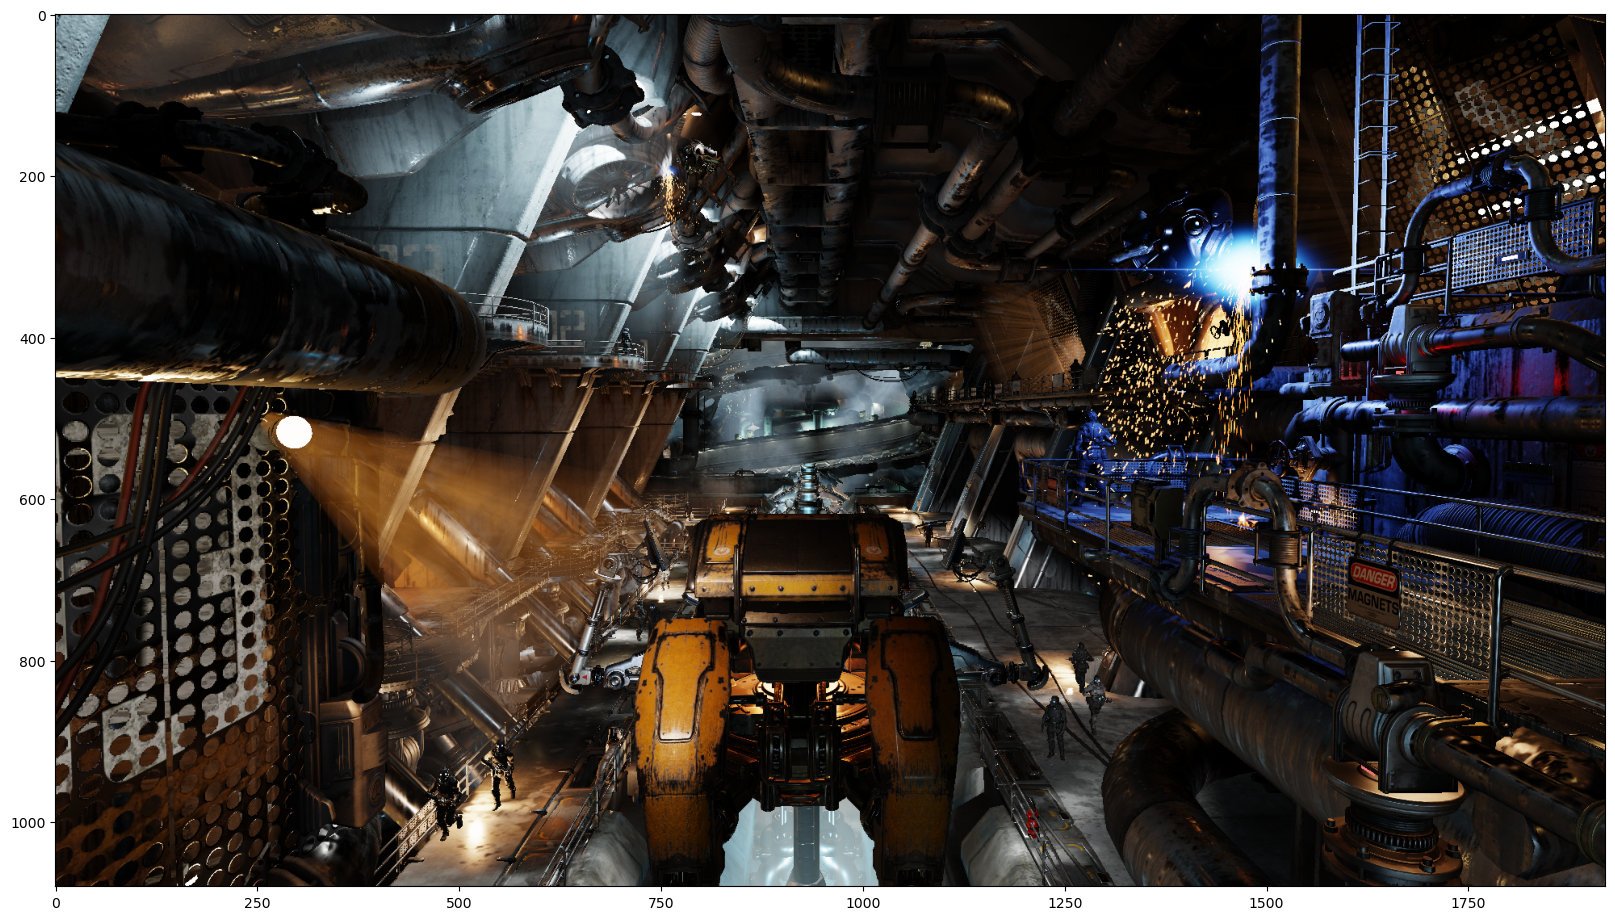

In [9]:
show_tensor(tens, exposure=10.0)

# What is a UNET?


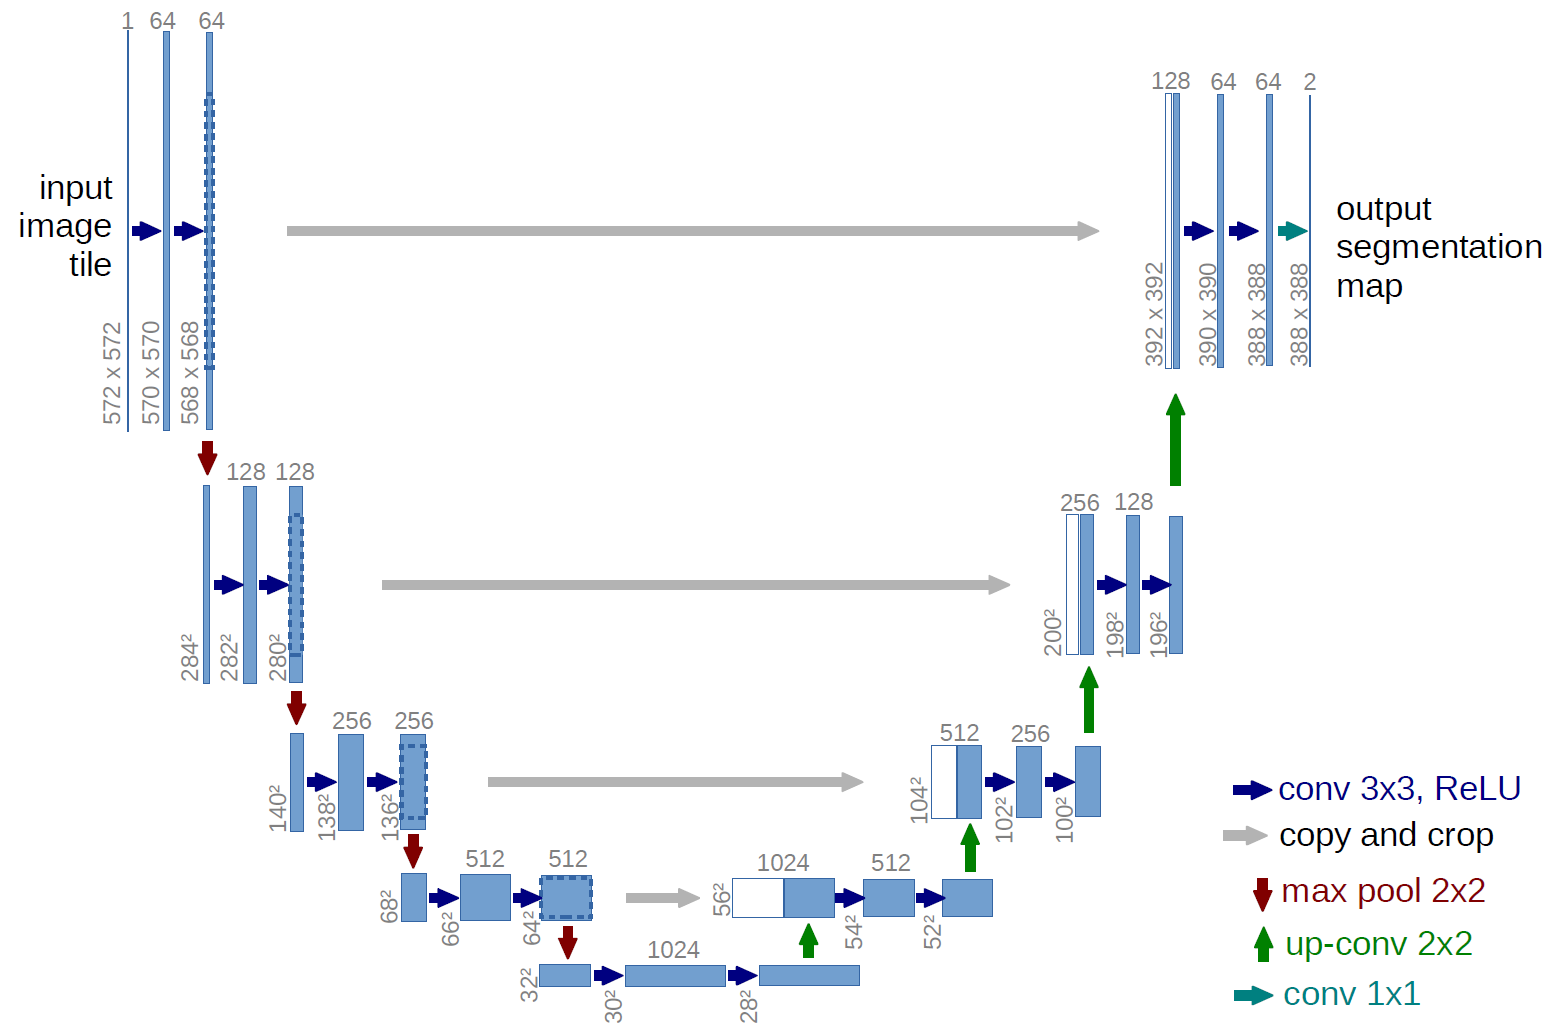

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as tvf
import numpy as np

from NeuralNetworks.NN_Base import Model_Base
from Config.Config import TensorType, ShapeType
from typing import Optional, Tuple


class DoubleConv(nn.Module):
    """
    Double Conv Block of UNET

    Attributes
    ----------
    in_channels : int
        Amount of input channels to downsample block
    out_channels : int
        Amount of output channels to downsample block
    ----------
    """

    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x: TensorType = None) -> TensorType:
        assert x is not None, "Input tensor X can't be None!"
        return self.conv(x)


class DownsampleBlock(nn.Module):
    """
    Downsample Block of UNET

    Attributes
    ----------
    in_channels : int
        Amount of input channels to downsample block
    out_channels : int
        Amount of output channels to downsample block
    pool_layer: Optional[nn.Module]
        Optional pooling layer for block, if not specified == nn.MaxPool2d(kernel_size=(2, 2), stride=2)
    ----------
    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        pool_layer: Optional[nn.Module] = None,
    ):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = pool_layer
        if pool_layer is None:
            self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=2)

    def forward(self, x: TensorType = None) -> Tuple[TensorType, TensorType]:
        assert x is not None, "Input tensor X can't be None!"

        conv_out = self.conv(x)
        return self.pool(conv_out), conv_out


class UpsampleBlock(nn.Module):
    """
    Upsample Block of UNET

    Attributes
    ----------
    in_channels : int
        Amount of input channels to upsample block
    out_channels : int
        Amount of output channels to upsample block
    ----------
    """

    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv_transpose2d = nn.ConvTranspose2d(
            in_channels, out_channels, kernel_size=2, stride=2
        )
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(
        self, x: TensorType = None, skip_connection: TensorType = None
    ) -> TensorType:
        assert (
            x is not None and skip_connection is not None
        ), "Input tensor X and skip_connection can't be None!"

        x = self.conv_transpose2d(x)
        # if shape of skip connection is not equal to input tensor, then just resize it
        # It may differ with 2,1 pixels in dim, due to pooling (max pool)
        if skip_connection.shape != x.shape:
            x = tvf.resize(x, size=(skip_connection.size(-2), skip_connection.size(-1)))

        x = torch.cat([skip_connection, x], dim=1)
        return self.conv(x)


class Model_UNET(Model_Base):
    """
    UNET architecture based model

    Attributes
    ----------
    name : str
        Name of Model
    input_shape : ShapeType (look at Config.py)
        Input shape to the network
    in_channels : int
        Number of input channels to the network
    out_channels : int
        Number of output channels to the network
    ----------
    """

    def __init__(
        self,
        name: str = "Model_UNET",
        input_shape: ShapeType = (1, 3, 1920, 1080),
        in_channels: int = 3,
        out_channels: int = 2,
    ):
        super().__init__(name, input_shape)

        # Uniforms
        self.in_channels = in_channels
        self.out_channels = out_channels

        # Amout of conv features per layer
        conv_features = np.array([64, 128, 256, 512], dtype=np.int32)

        # Skip connections
        self.skip_connections = [
            torch.empty((1, 1, 1, 1)),
            torch.empty((1, 1, 1, 1)),
            torch.empty((1, 1, 1, 1)),
            torch.empty((1, 1, 1, 1)),
        ]

        # Downsample layers
        self.downsample_block1 = DownsampleBlock(in_channels, conv_features[0])
        self.downsample_block2 = DownsampleBlock(conv_features[0], conv_features[1])
        self.downsample_block3 = DownsampleBlock(conv_features[1], conv_features[2])
        self.downsample_block4 = DownsampleBlock(conv_features[2], conv_features[3])

        # Bottleneck layer
        self.bottleneck = DoubleConv(conv_features[3], conv_features[3] * 2)

        # Upsample layers
        self.upsample_block1 = UpsampleBlock(conv_features[3] * 2, conv_features[3])
        self.upsample_block2 = UpsampleBlock(conv_features[2] * 2, conv_features[2])
        self.upsample_block3 = UpsampleBlock(conv_features[1] * 2, conv_features[1])
        self.upsample_block4 = UpsampleBlock(conv_features[0] * 2, conv_features[0])

        # Final convolution
        self.final_conv = nn.Conv2d(
            conv_features[0], self.out_channels, kernel_size=1
        )  # 1x1 convolution at the end

    def forward(self, x: TensorType = None) -> TensorType:
        assert x is not None, "Input tensor X can't be None!"

        # Downsample
        for idx in [1, 2, 3, 4]:
            downsample_block = getattr(self, "downsample_block{}".format(idx))
            x, x1 = downsample_block(x)
            self.skip_connections[idx - 1] = x1

        # Bottleneck
        x = self.bottleneck(x)

        # Upsample
        for idx in [1, 2, 3, 4]:
            upsample_block = getattr(self, "upsample_block{}".format(idx))
            x = upsample_block(
                x, self.skip_connections[len(self.skip_connections) - idx]
            )

        # Final, last conv
        return self.final_conv(x)

In [11]:
model = Model_UNET(in_channels=3, out_channels=2).to(device=CurrentDevice)
preds = model(b_tens[..., 500:628, 500:628].to(device=CurrentDevice))

In [12]:
print(model)

Model_UNET


In [13]:
from torchsummary import summary

ModuleNotFoundError: No module named 'torchsummary'

In [ ]:
show_tensor(tens[..., 500:628, 500:628], exposure=10.0)

In [ ]:
show_tensor_channels(preds.squeeze(0).cpu(), 2, 2, 2)

# Transposed convolution and their checkerboard artifact

In [ ]:
# Show training results with and without deconvolutions

In [ ]:
import torch.nn as nn

## Upscaling with Transposed Conv and Analitical Upscale + Conv

In [ ]:
show_tensor(tens[..., 500:800, :300], exposure=3.0,)

In [ ]:
conv_transpose2d_conv = nn.Sequential(
    nn.ConvTranspose2d(
    3, 3, kernel_size=1, stride=2)
)

upscale_conv = nn.Sequential(
    nn.Upsample(scale_factor=(2,2)),
    nn.Conv2d(3, 3, kernel_size=1), #1x1 conv
)

if False:
    torch.nn.init.xavier_uniform_(conv_transpose2d_conv[0].weight)   
    torch.nn.init.xavier_uniform_(upscale_conv[1].weight)     

out = conv_transpose2d_conv(tens)
out1 = upscale_conv(tens.unsqueeze(0)).squeeze(0)

show_tensor(out[..., :200, :300], exposure=3.0,)
show_tensor(out1[..., :200, :300], exposure=3.0)

## Example outputs of Transposed Conv
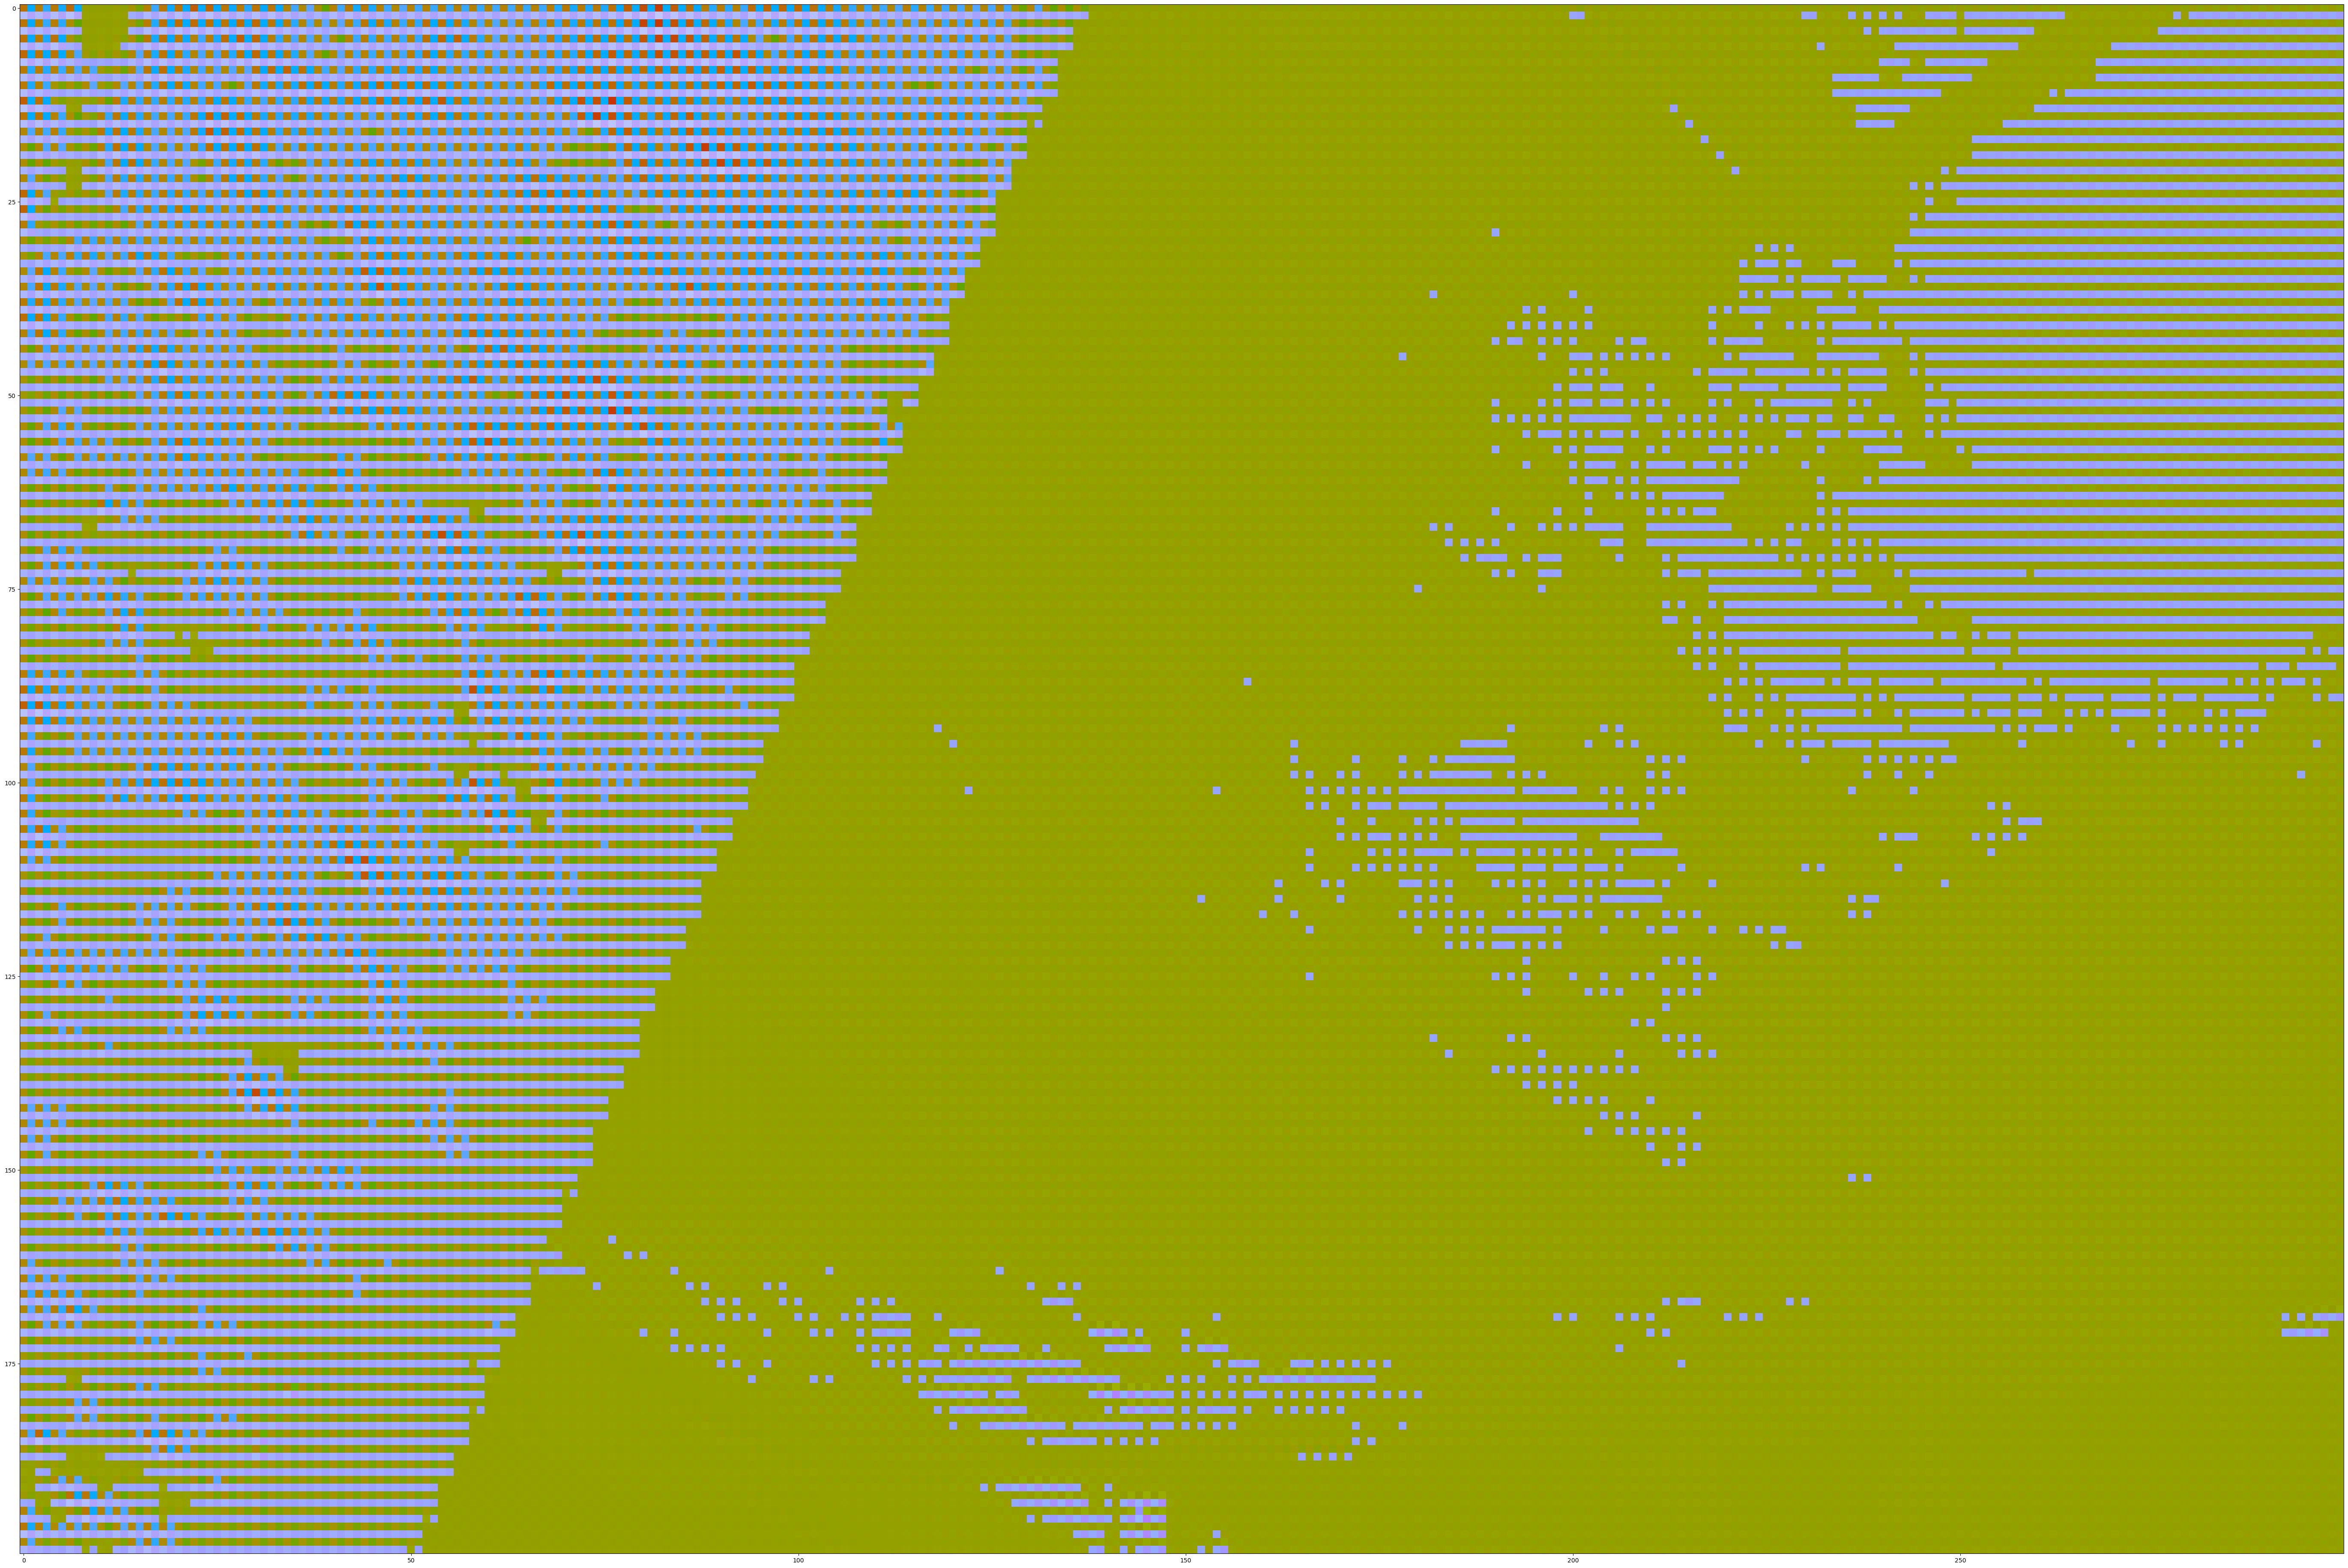
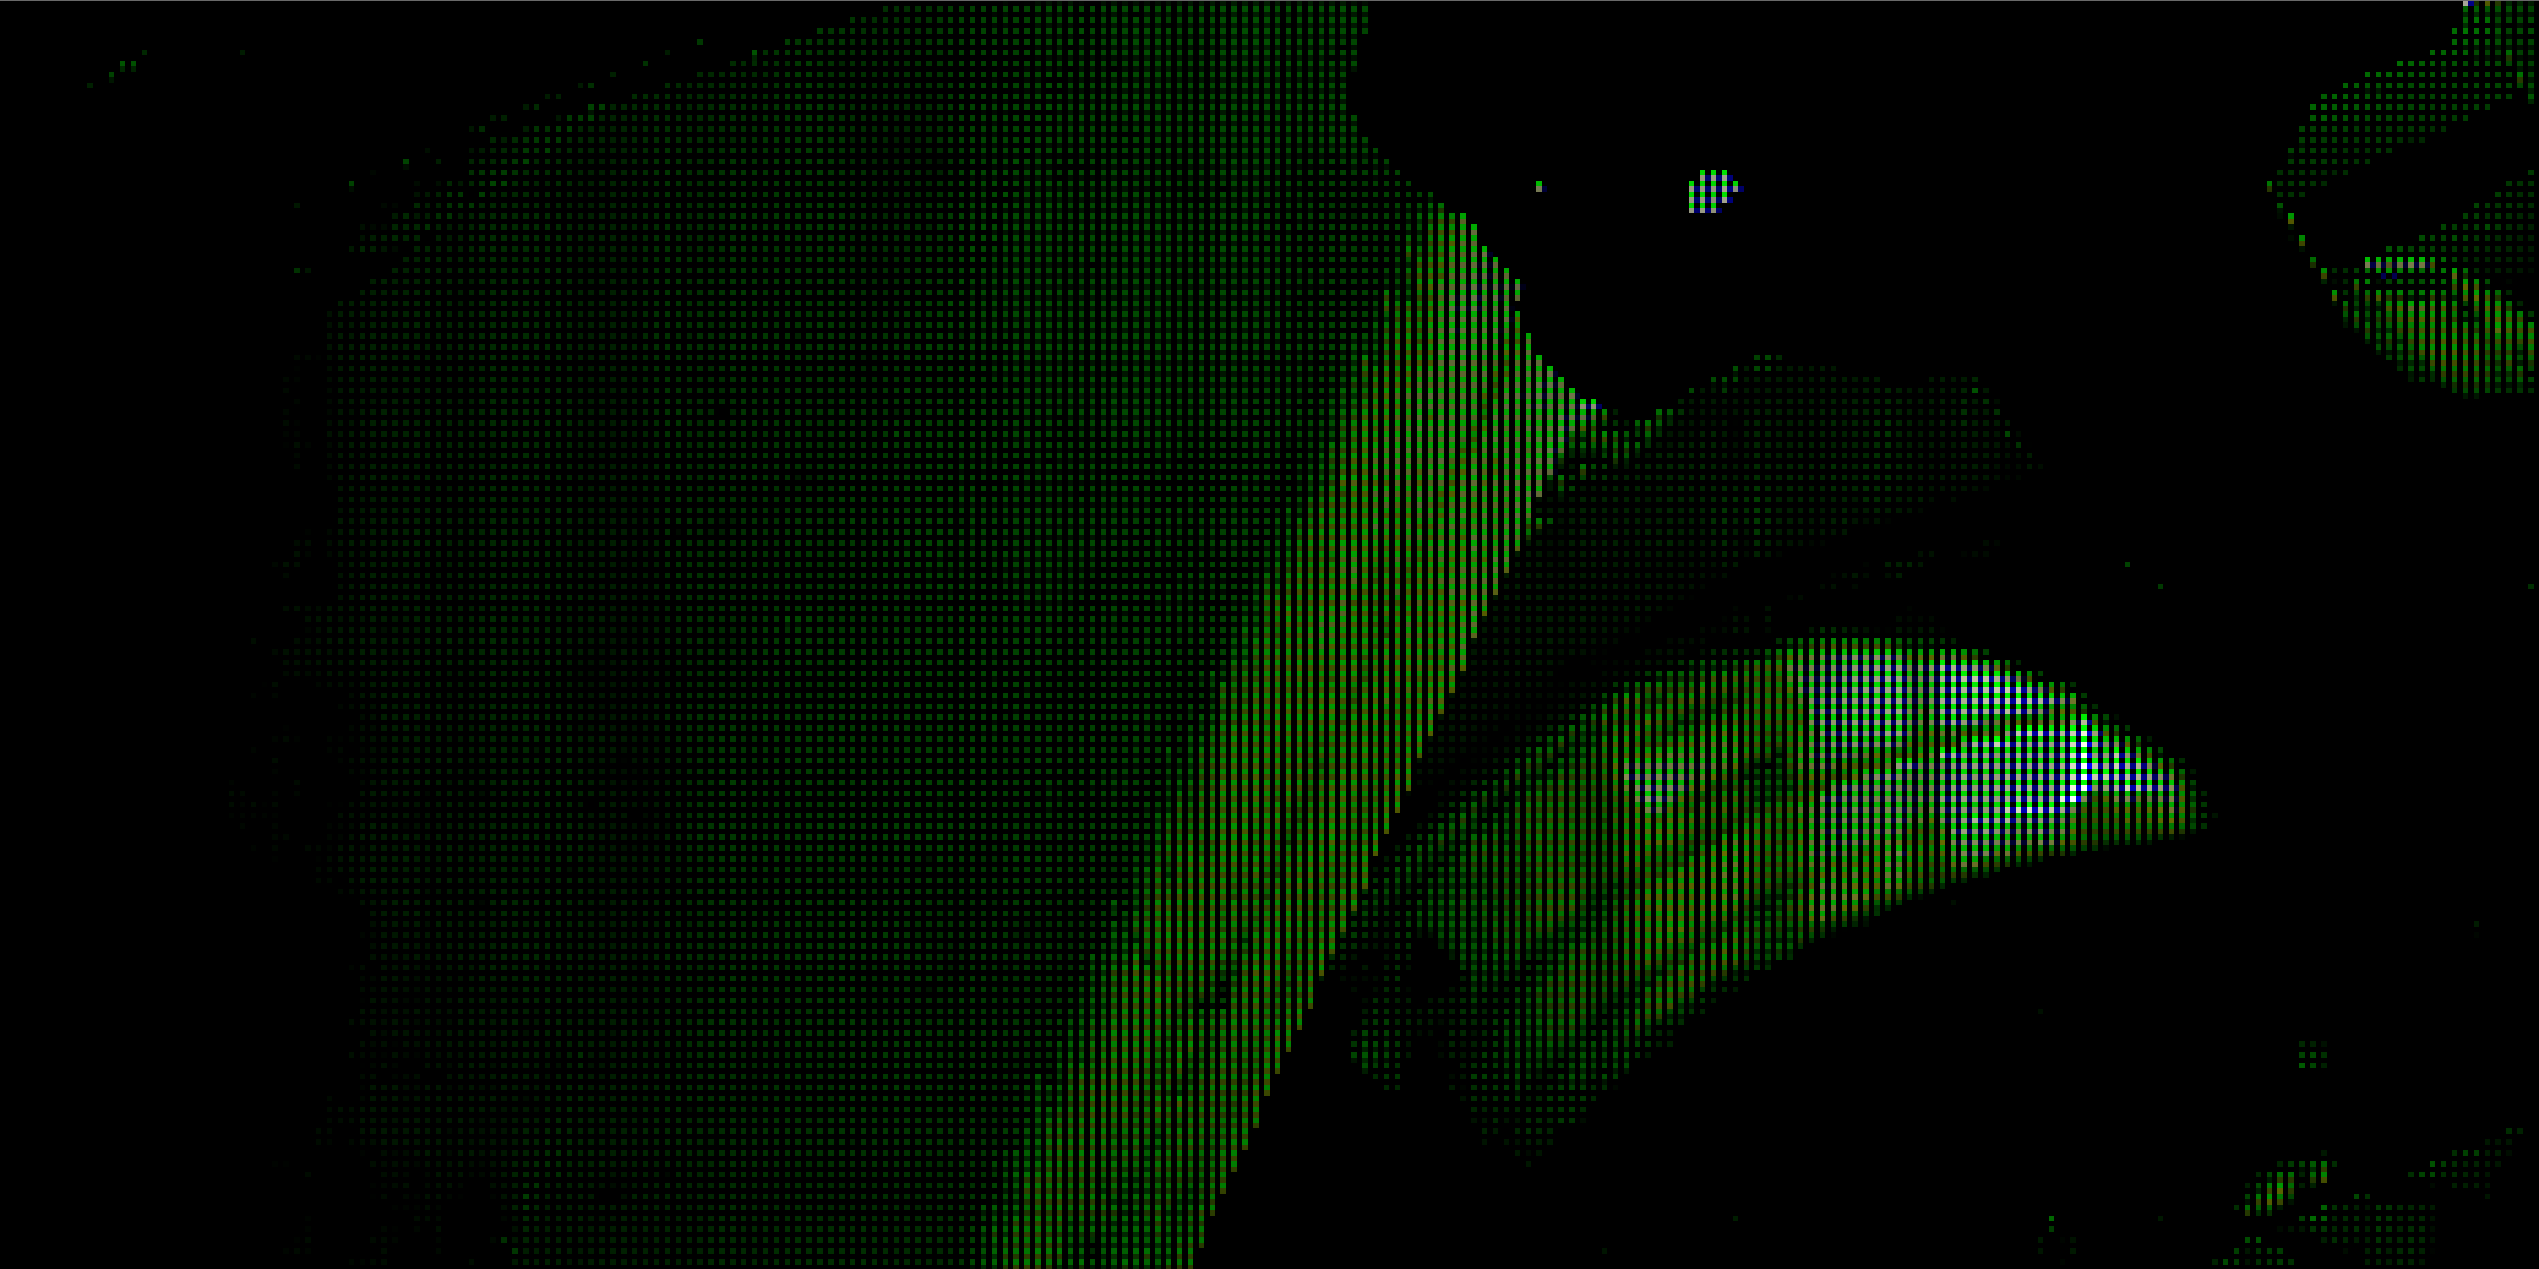

## Example outputs of Upscale NN + Conv
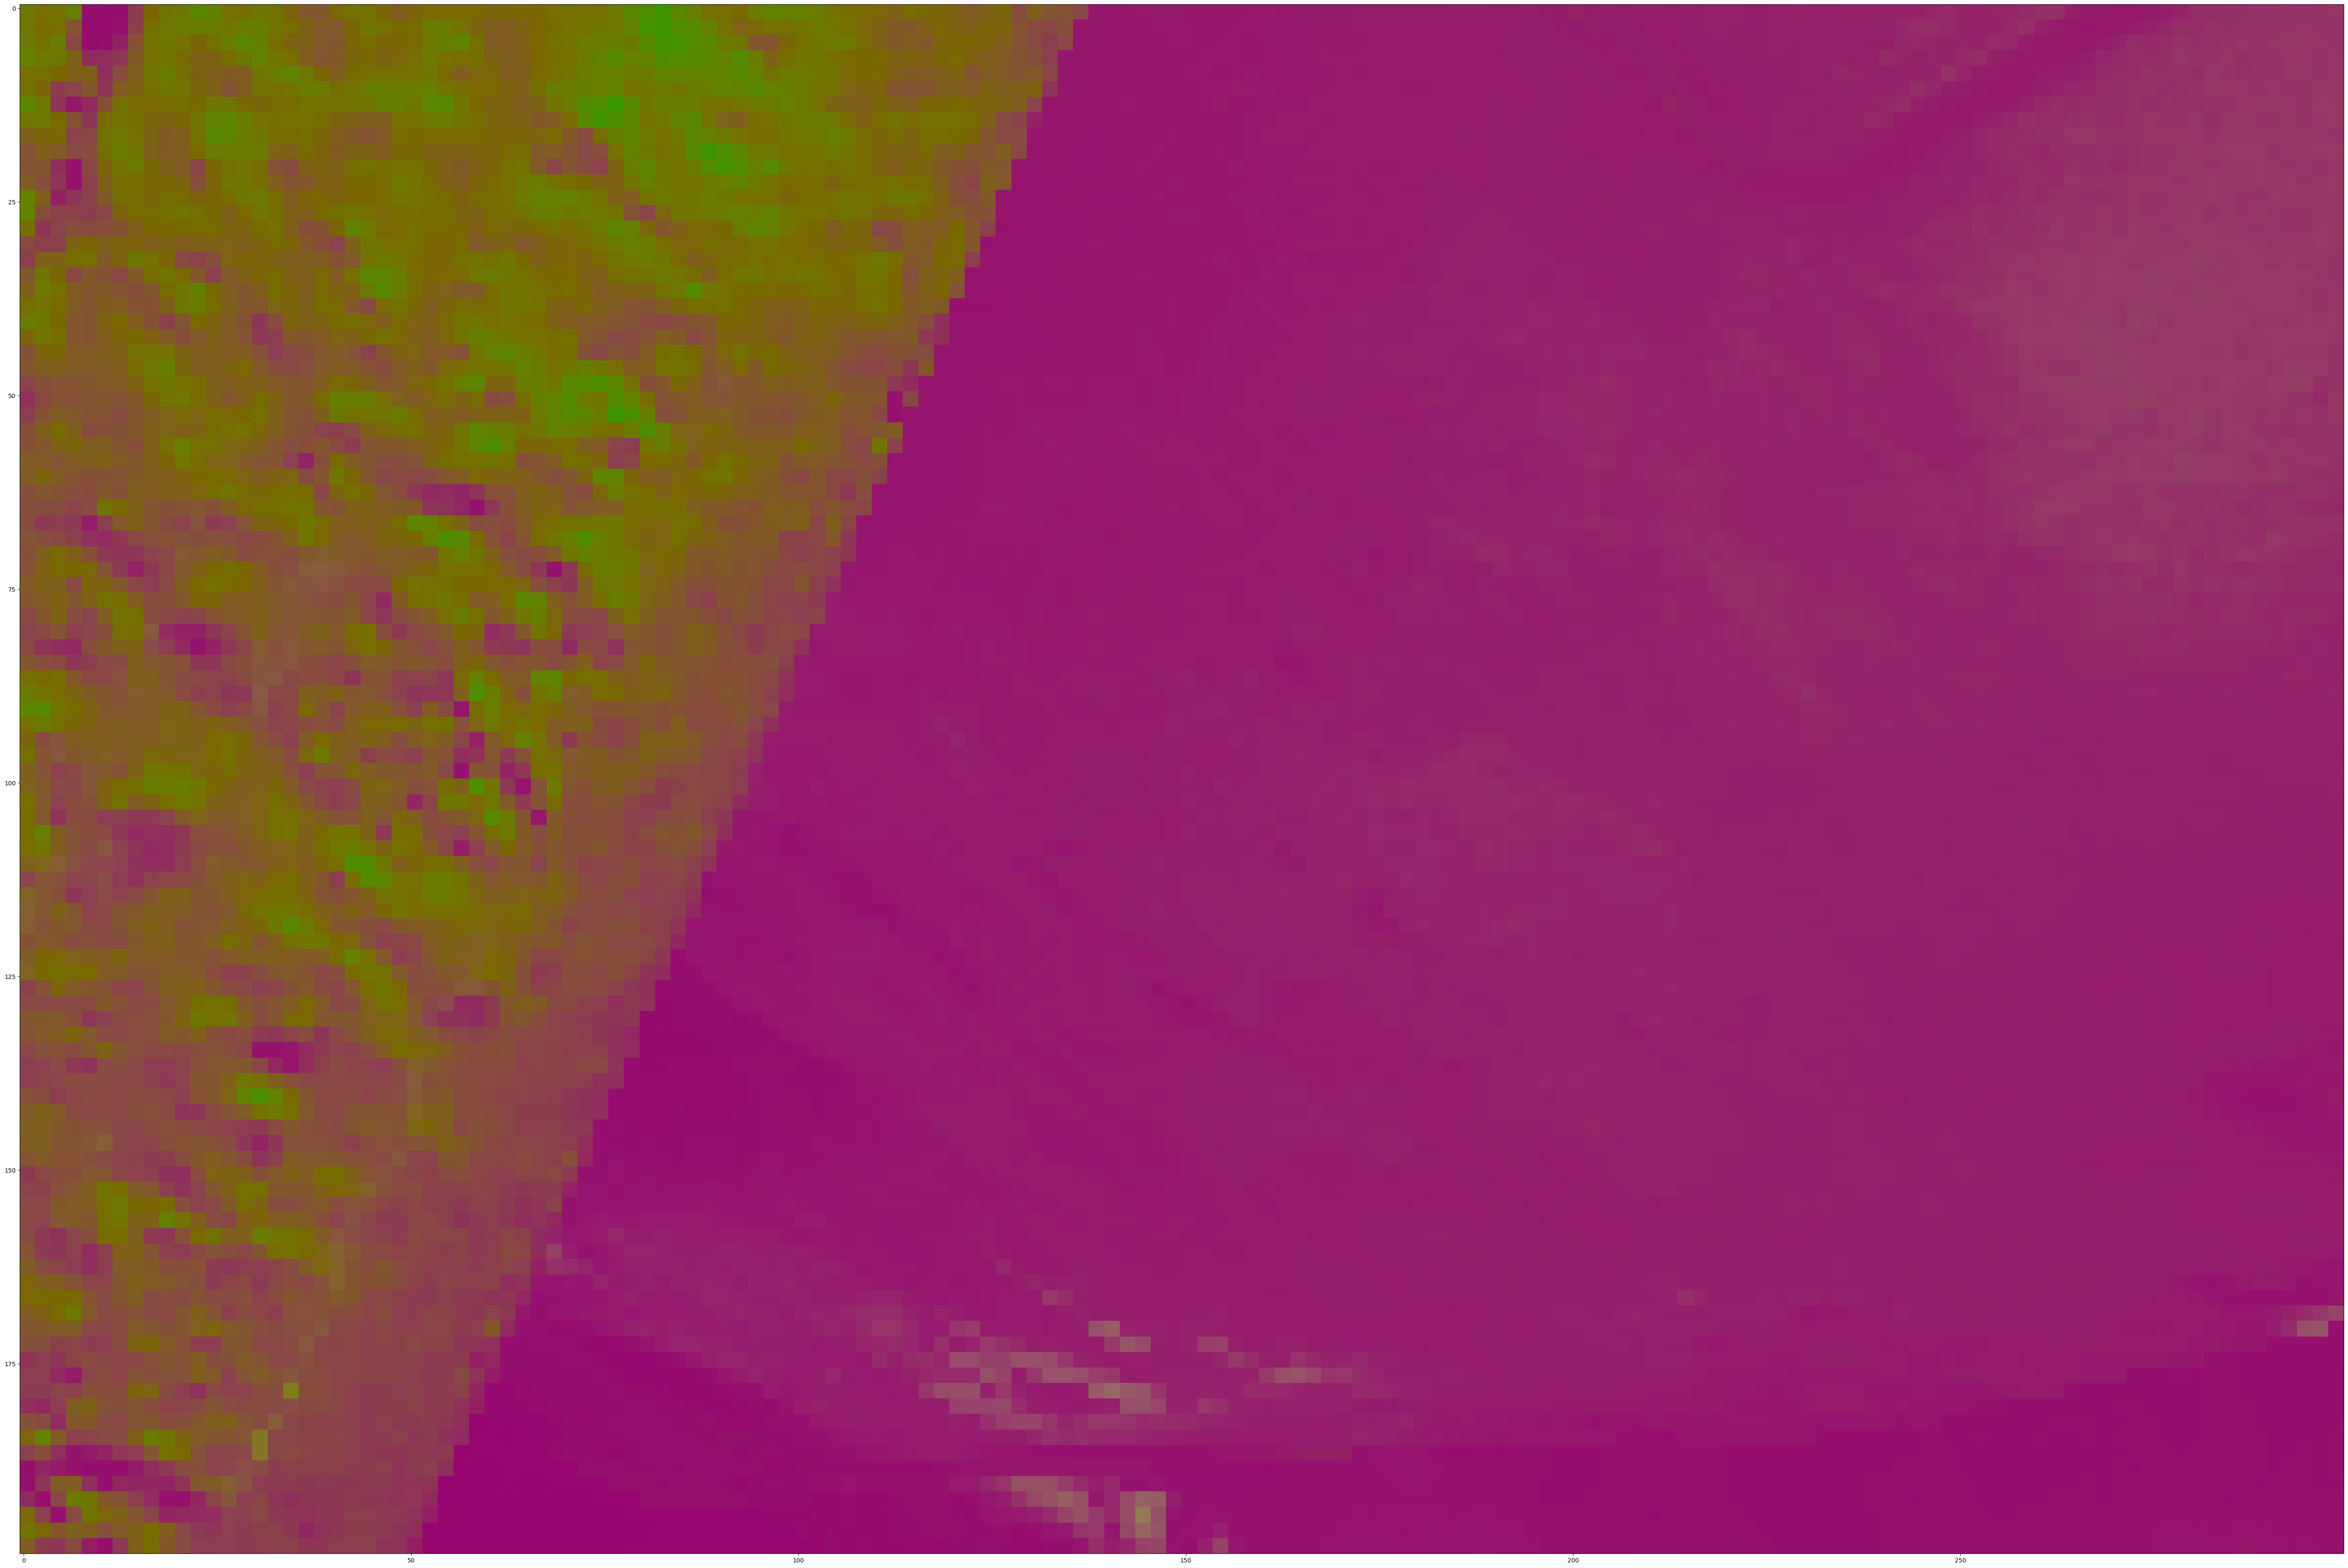
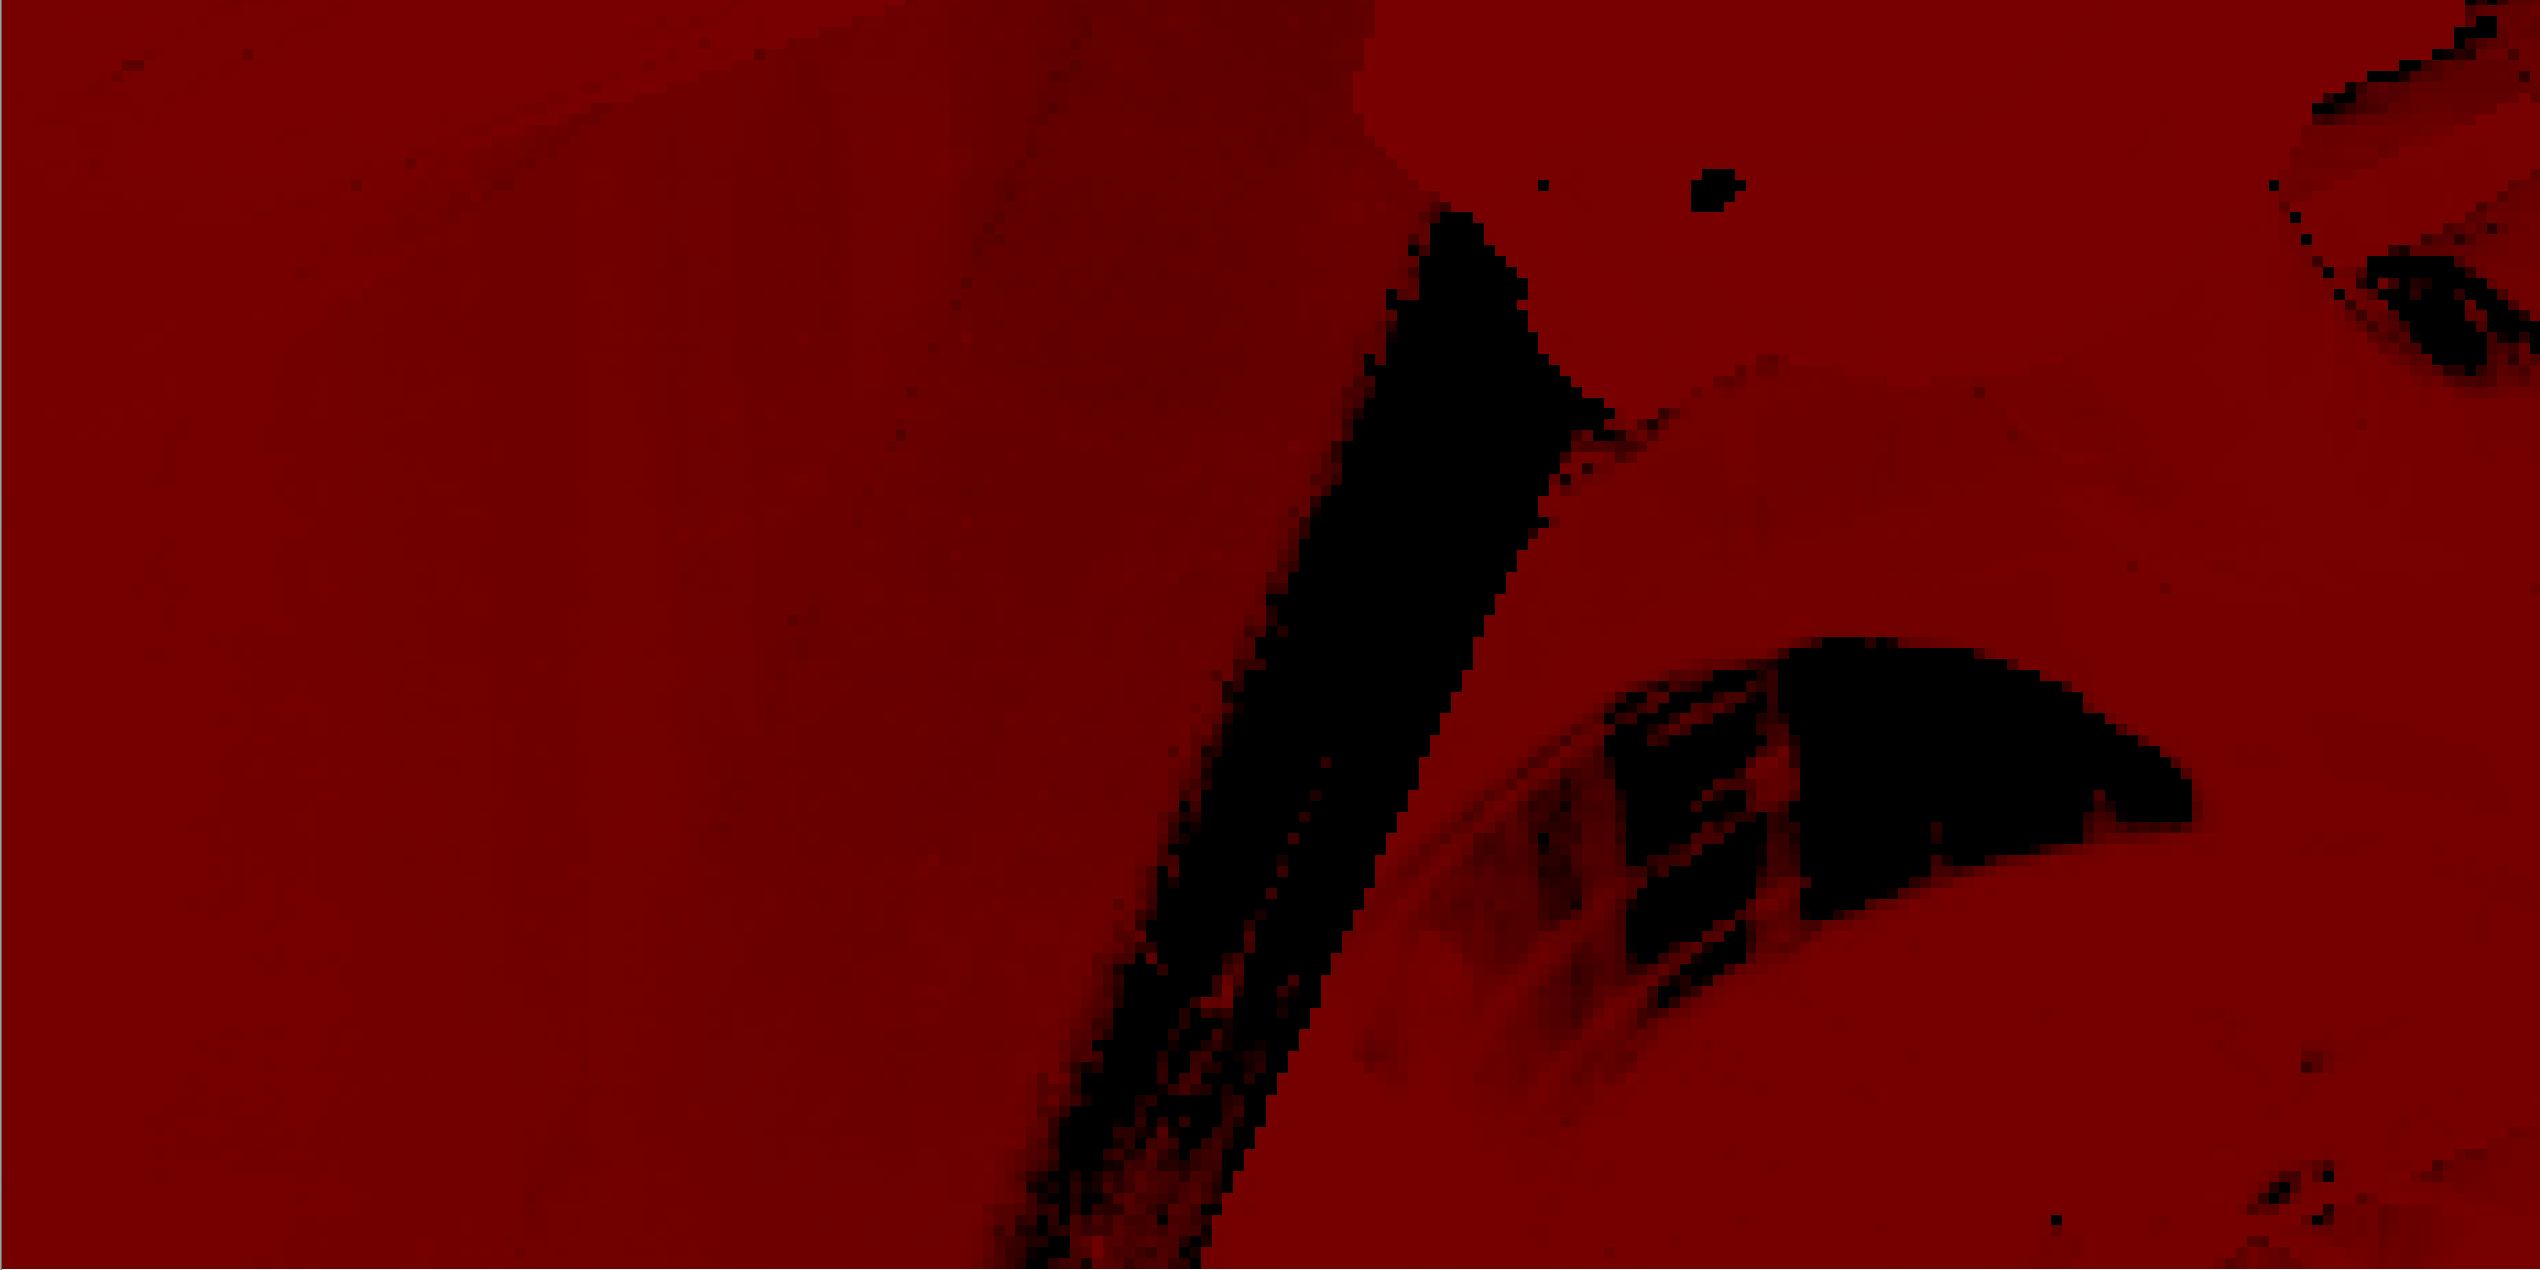

In [ ]:
# save_exr("F:/MASTERS/out.exr", out)
# save_exr("F:/MASTERS/out1.exr", out1)

# Why L1 norm is better than L2 norm for Super Resolution tasks?

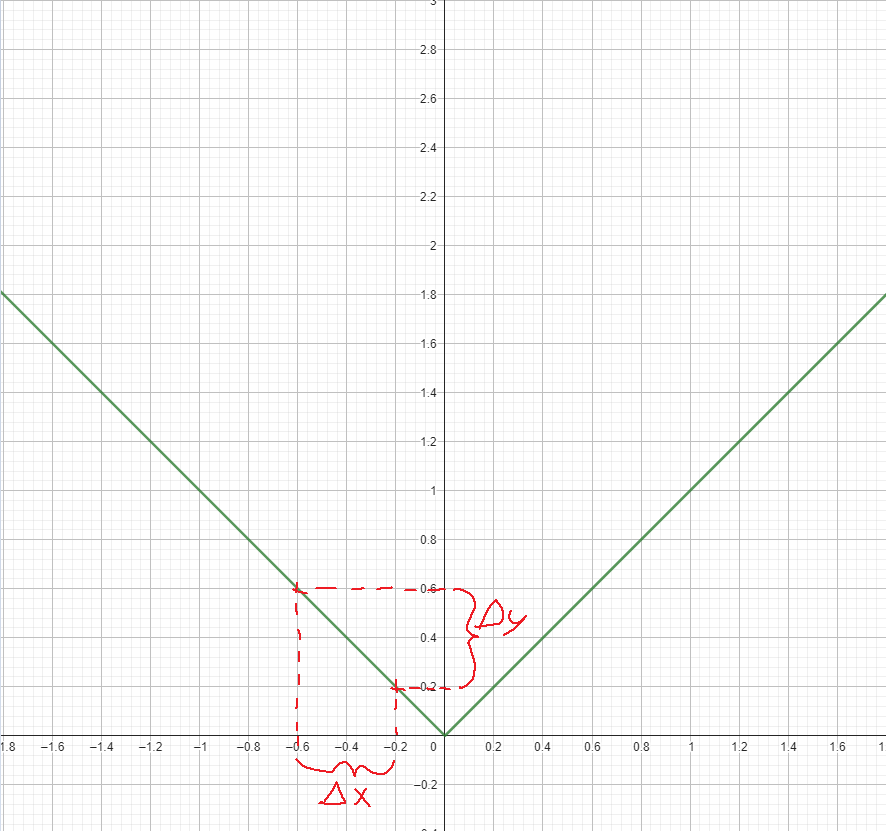

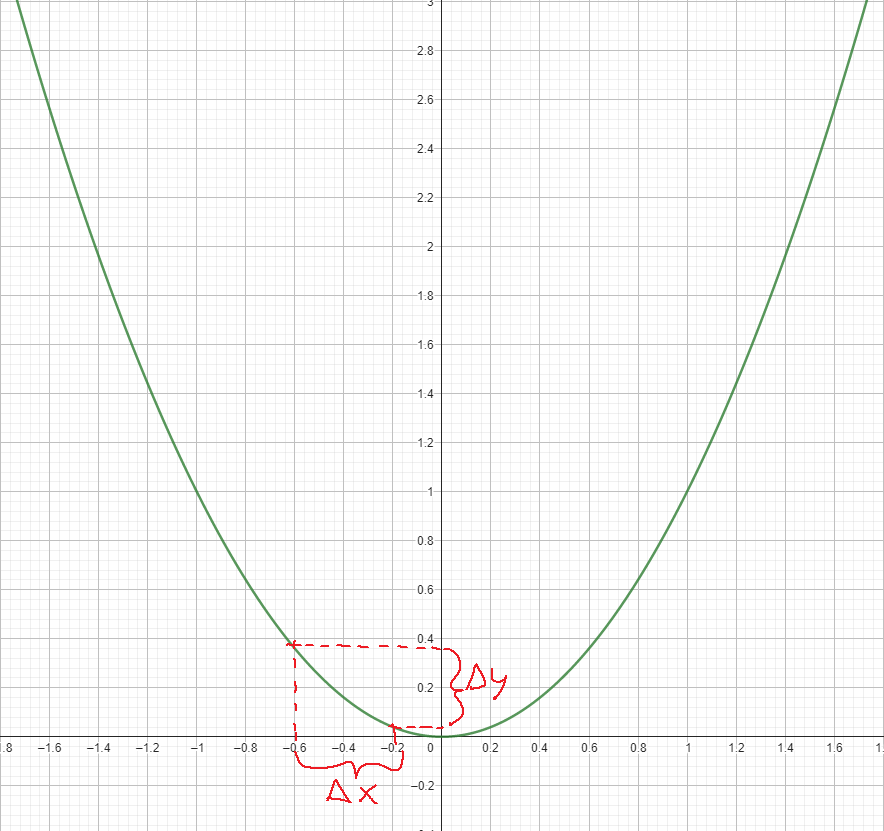

# Comparison

### Target (Ground-Truth)
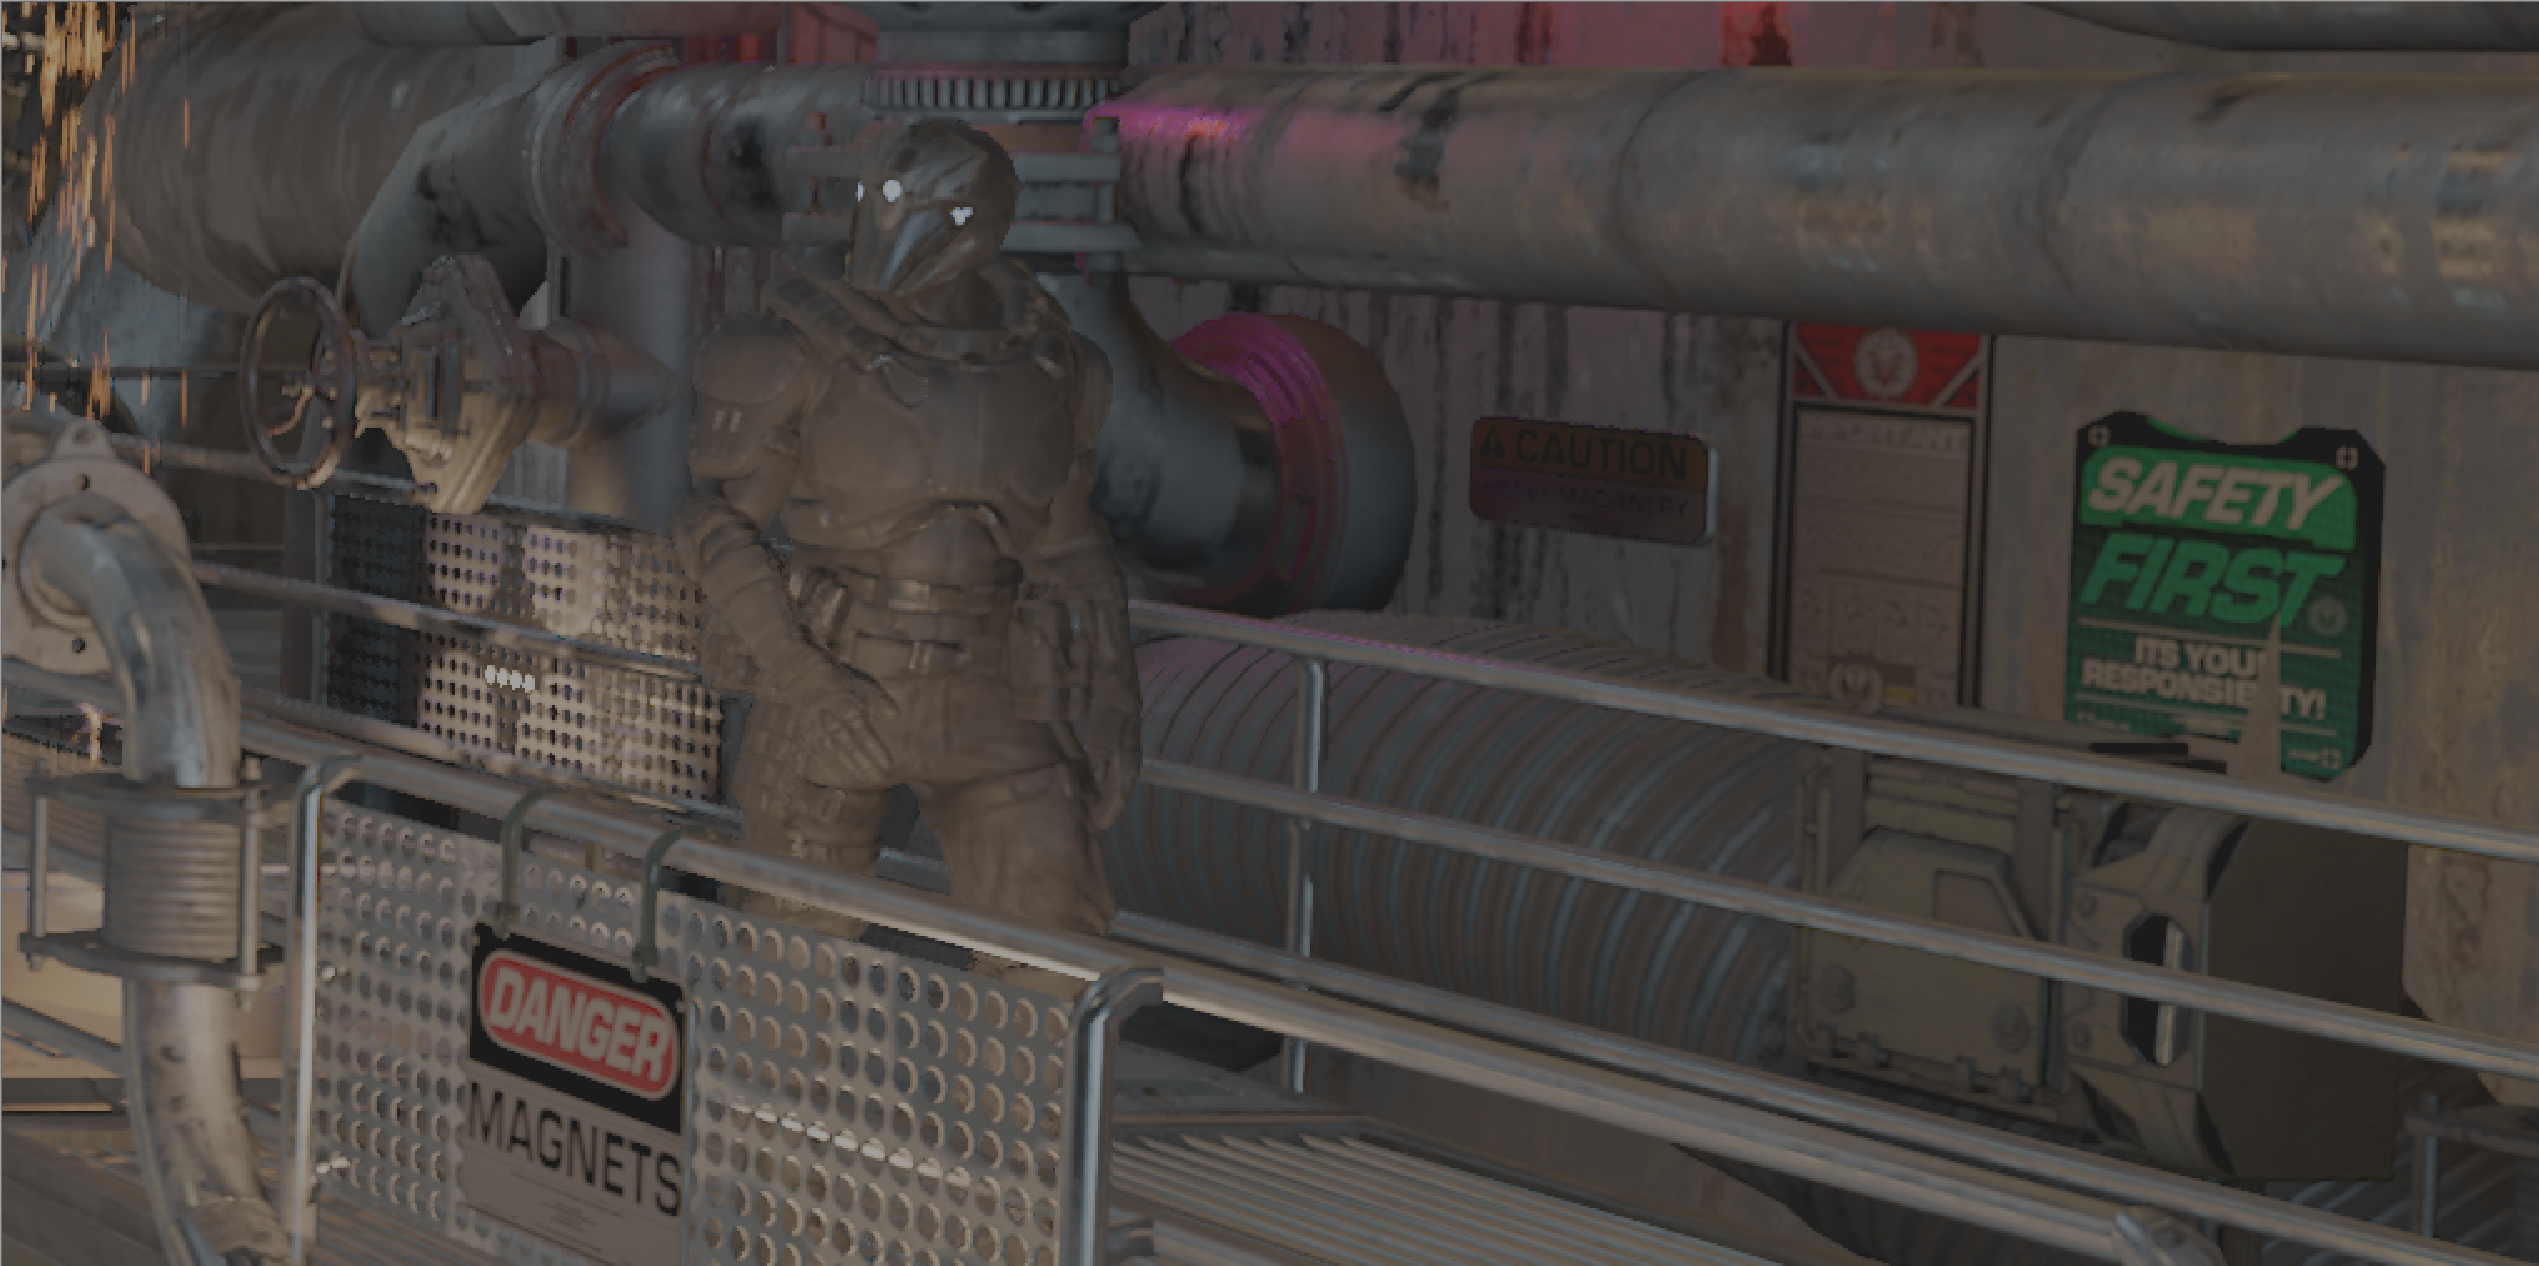

### MAE (L1) Prediction 
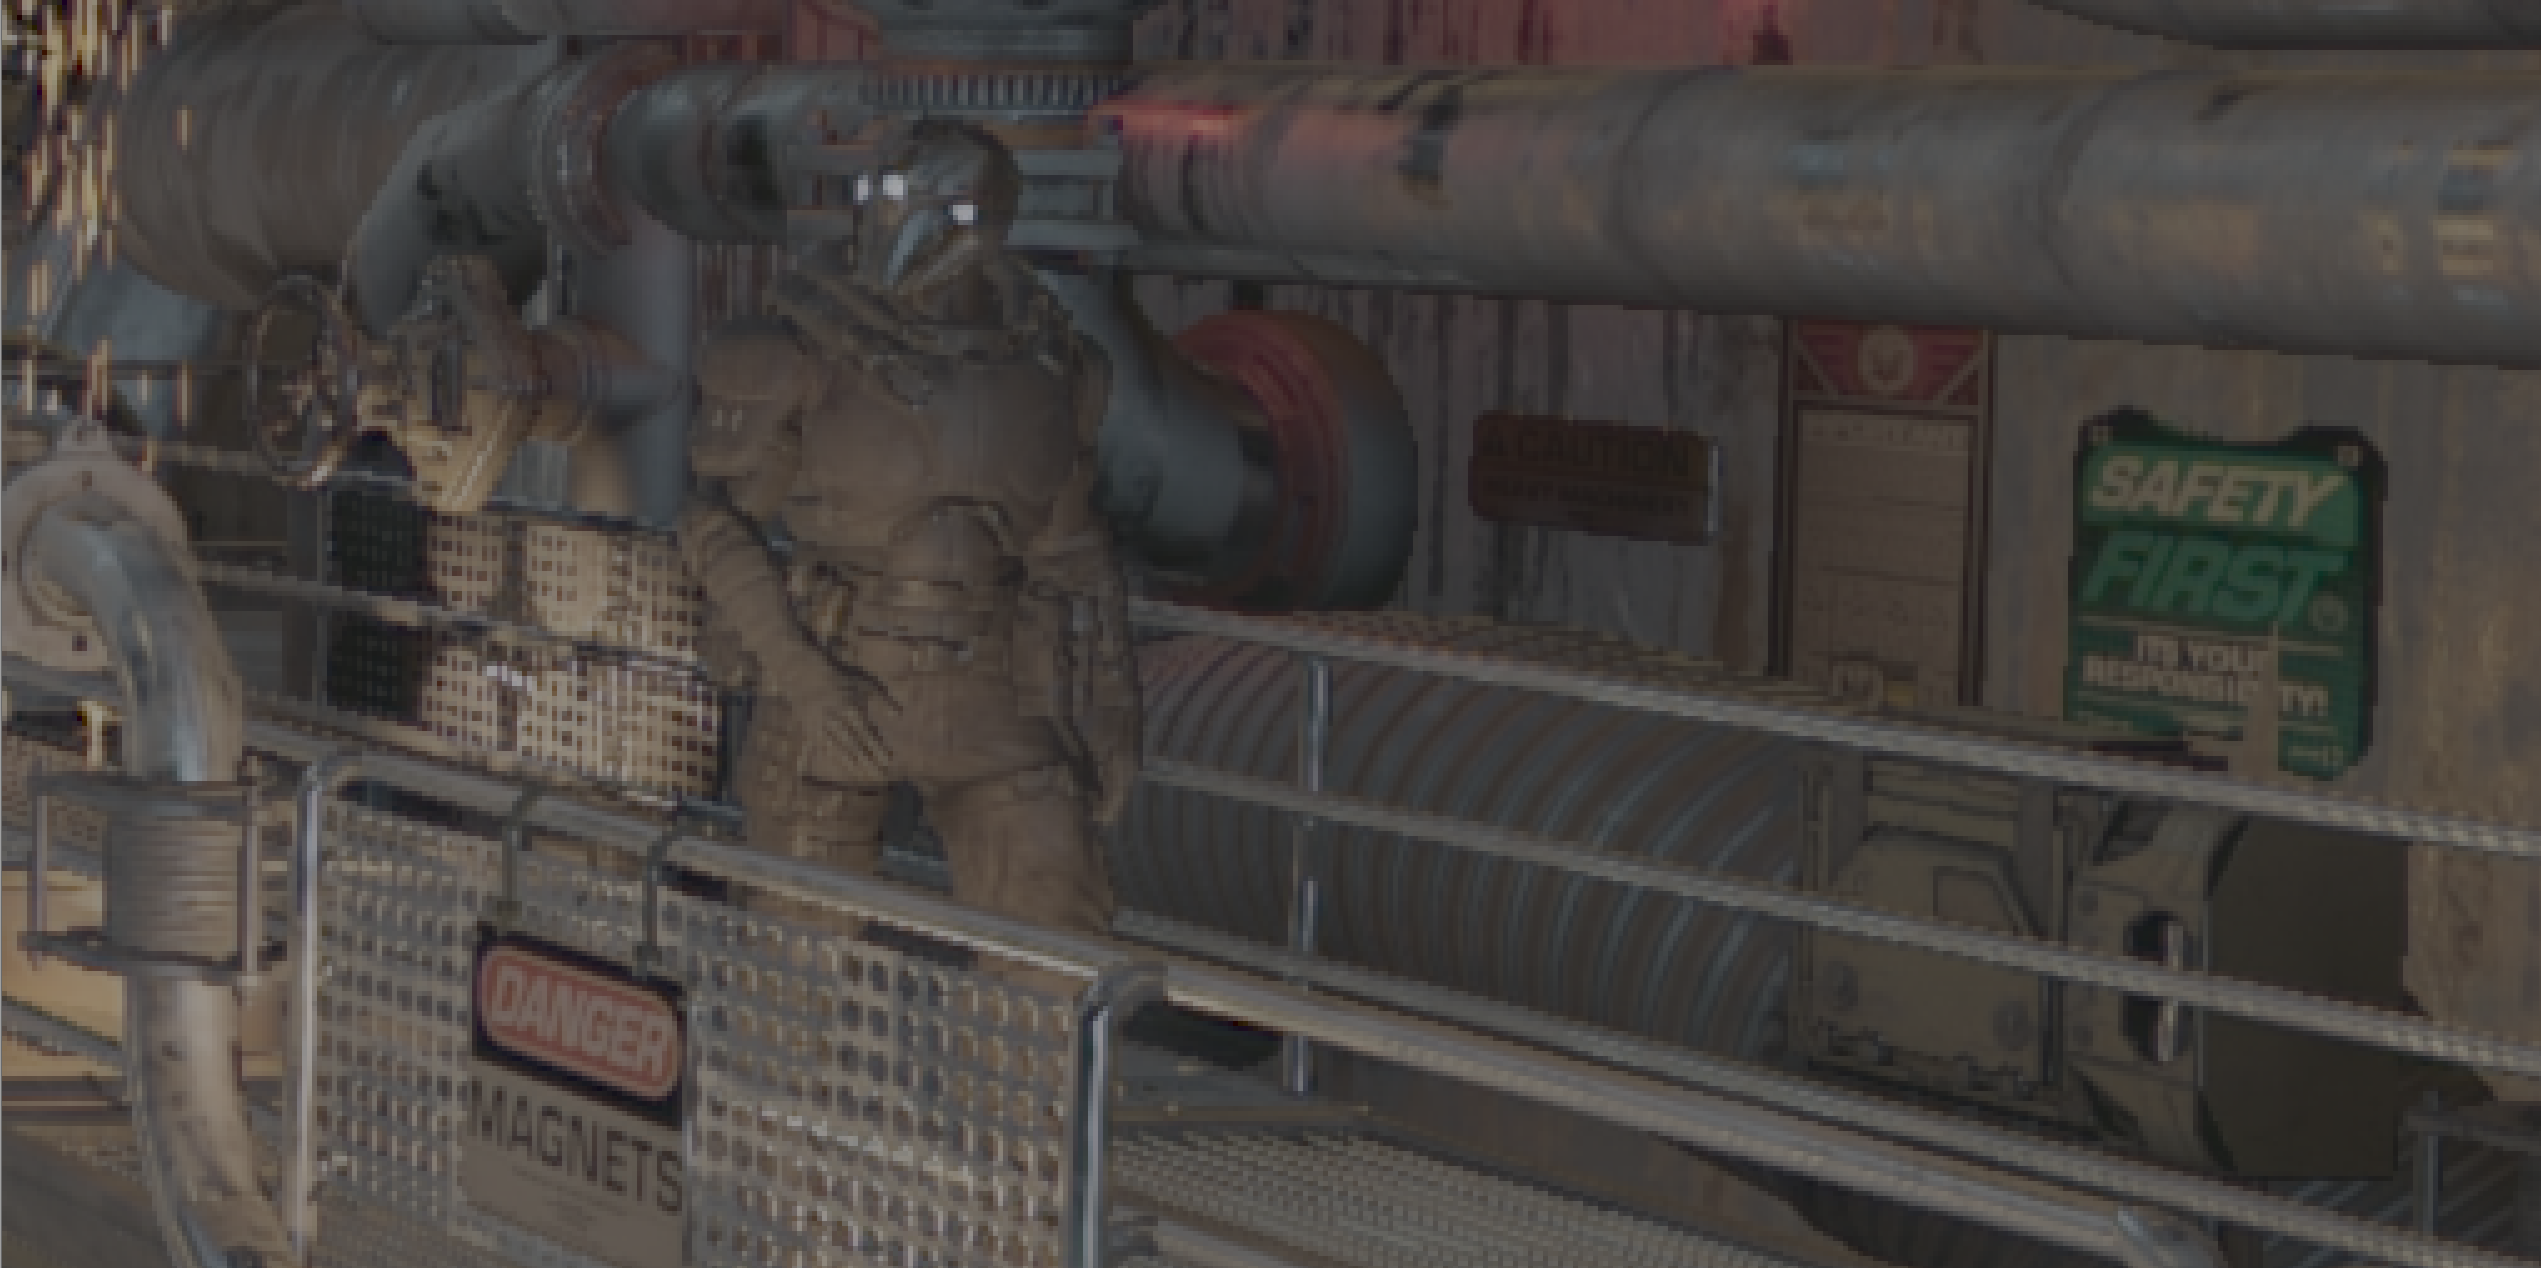

### MSE (L2) Prediction
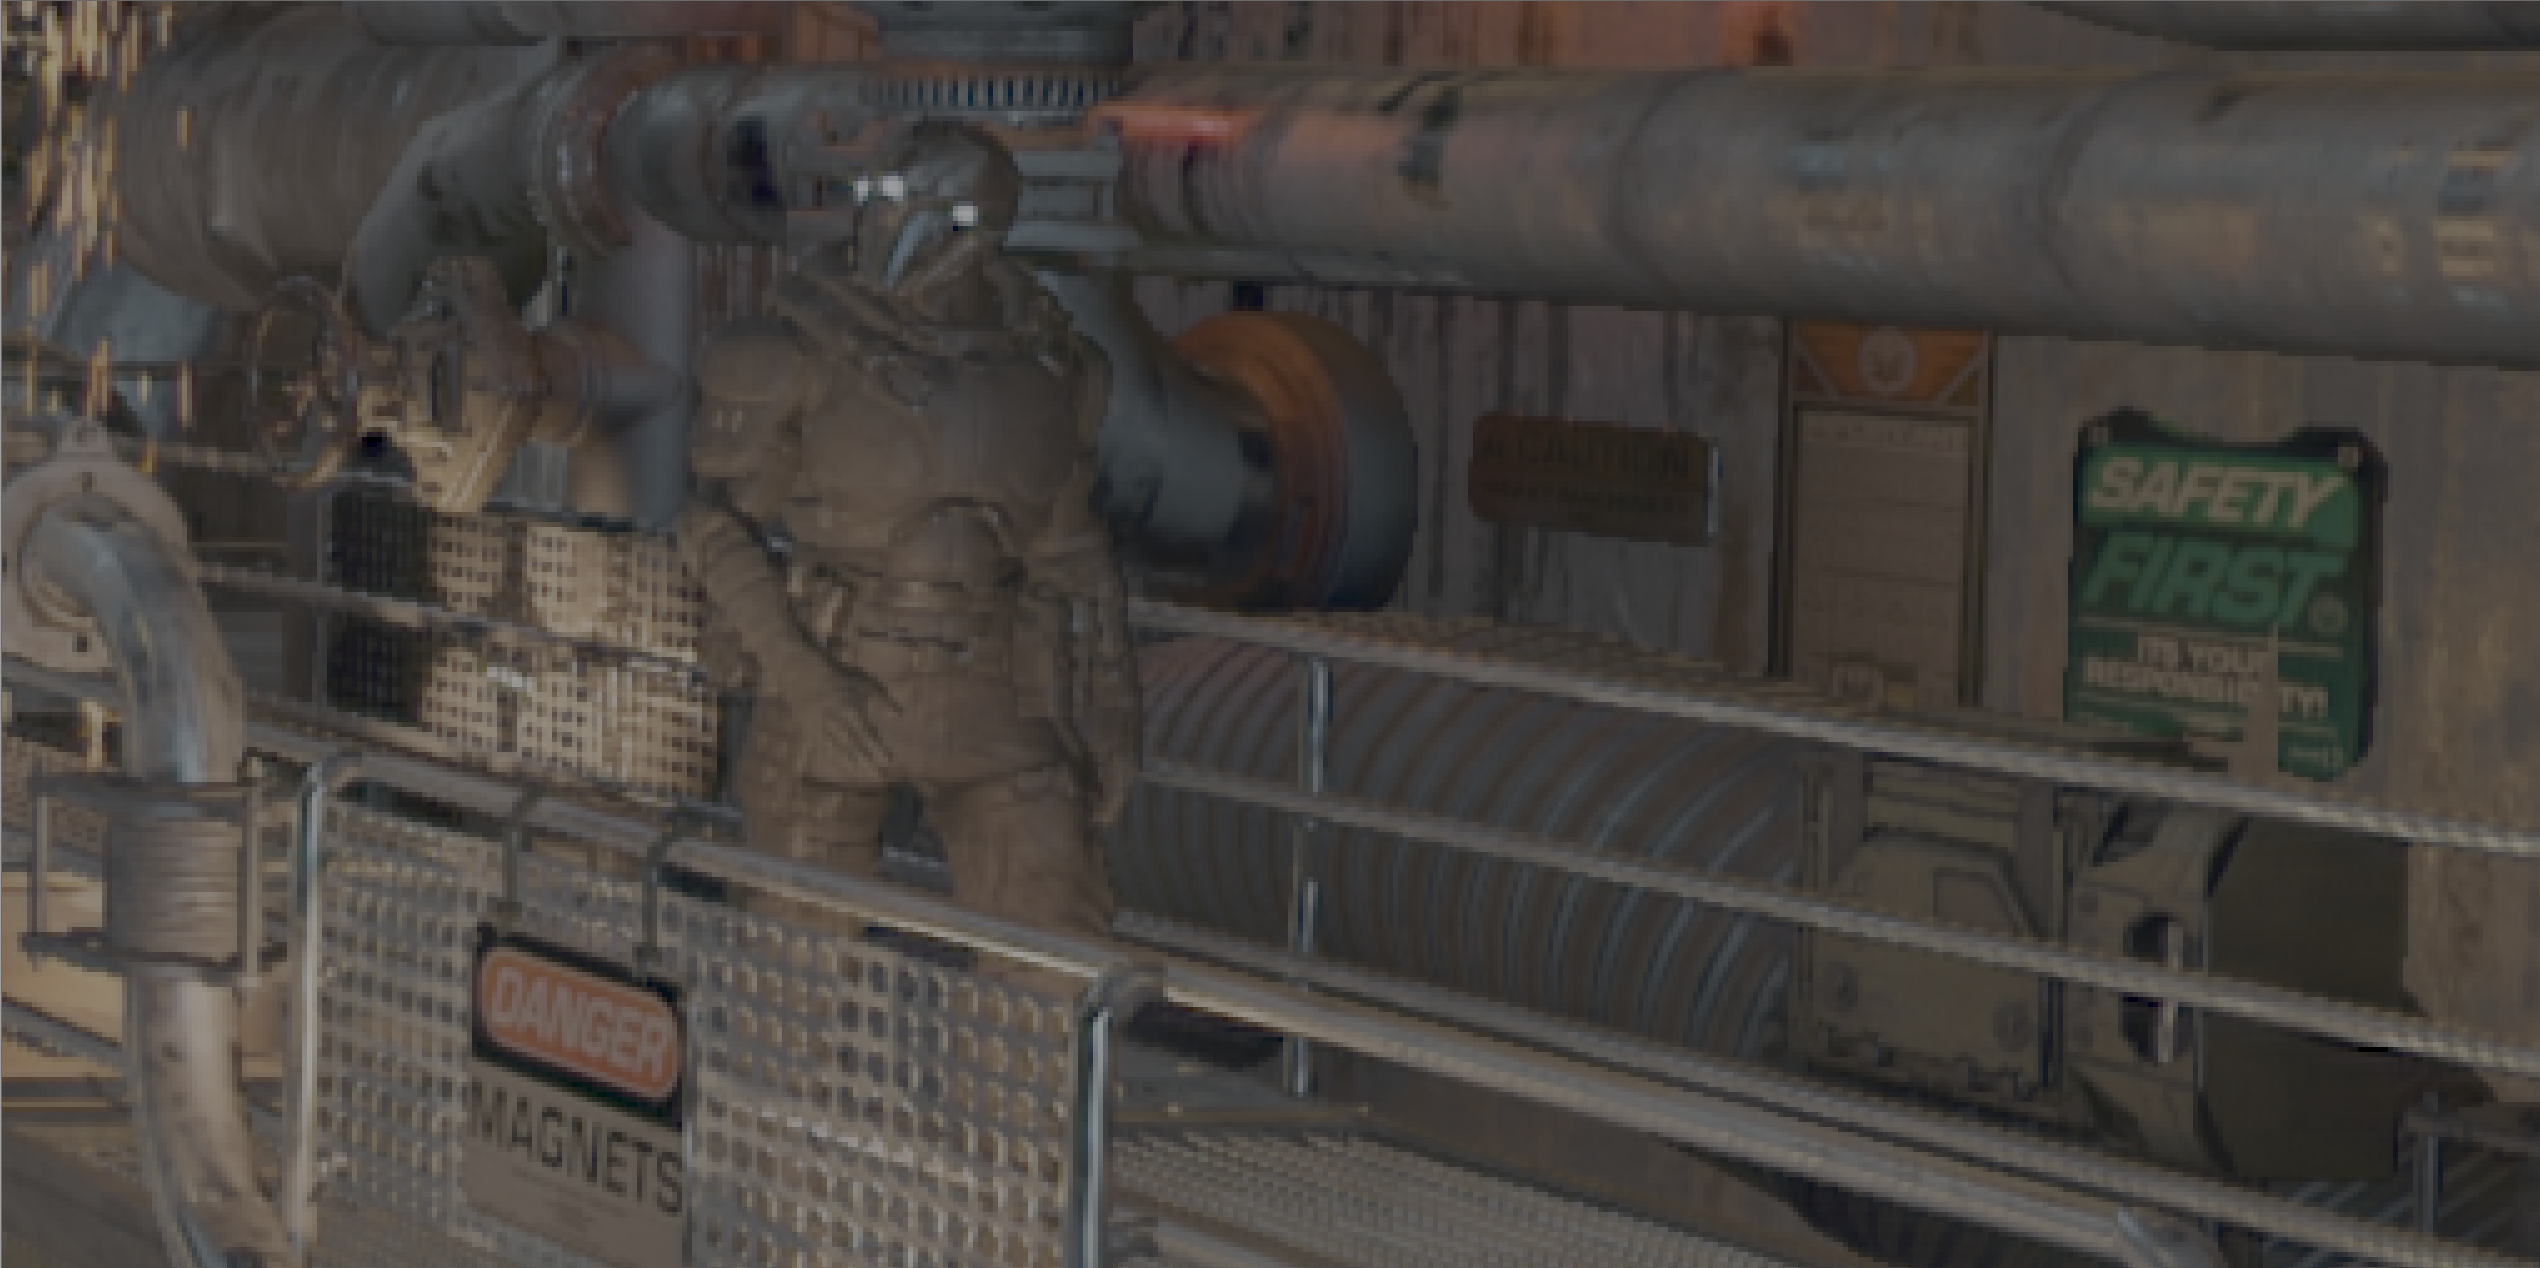

# What is a VGG Loss?

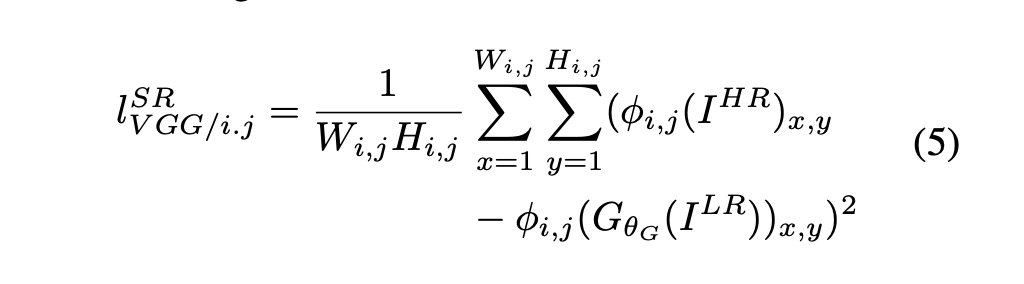

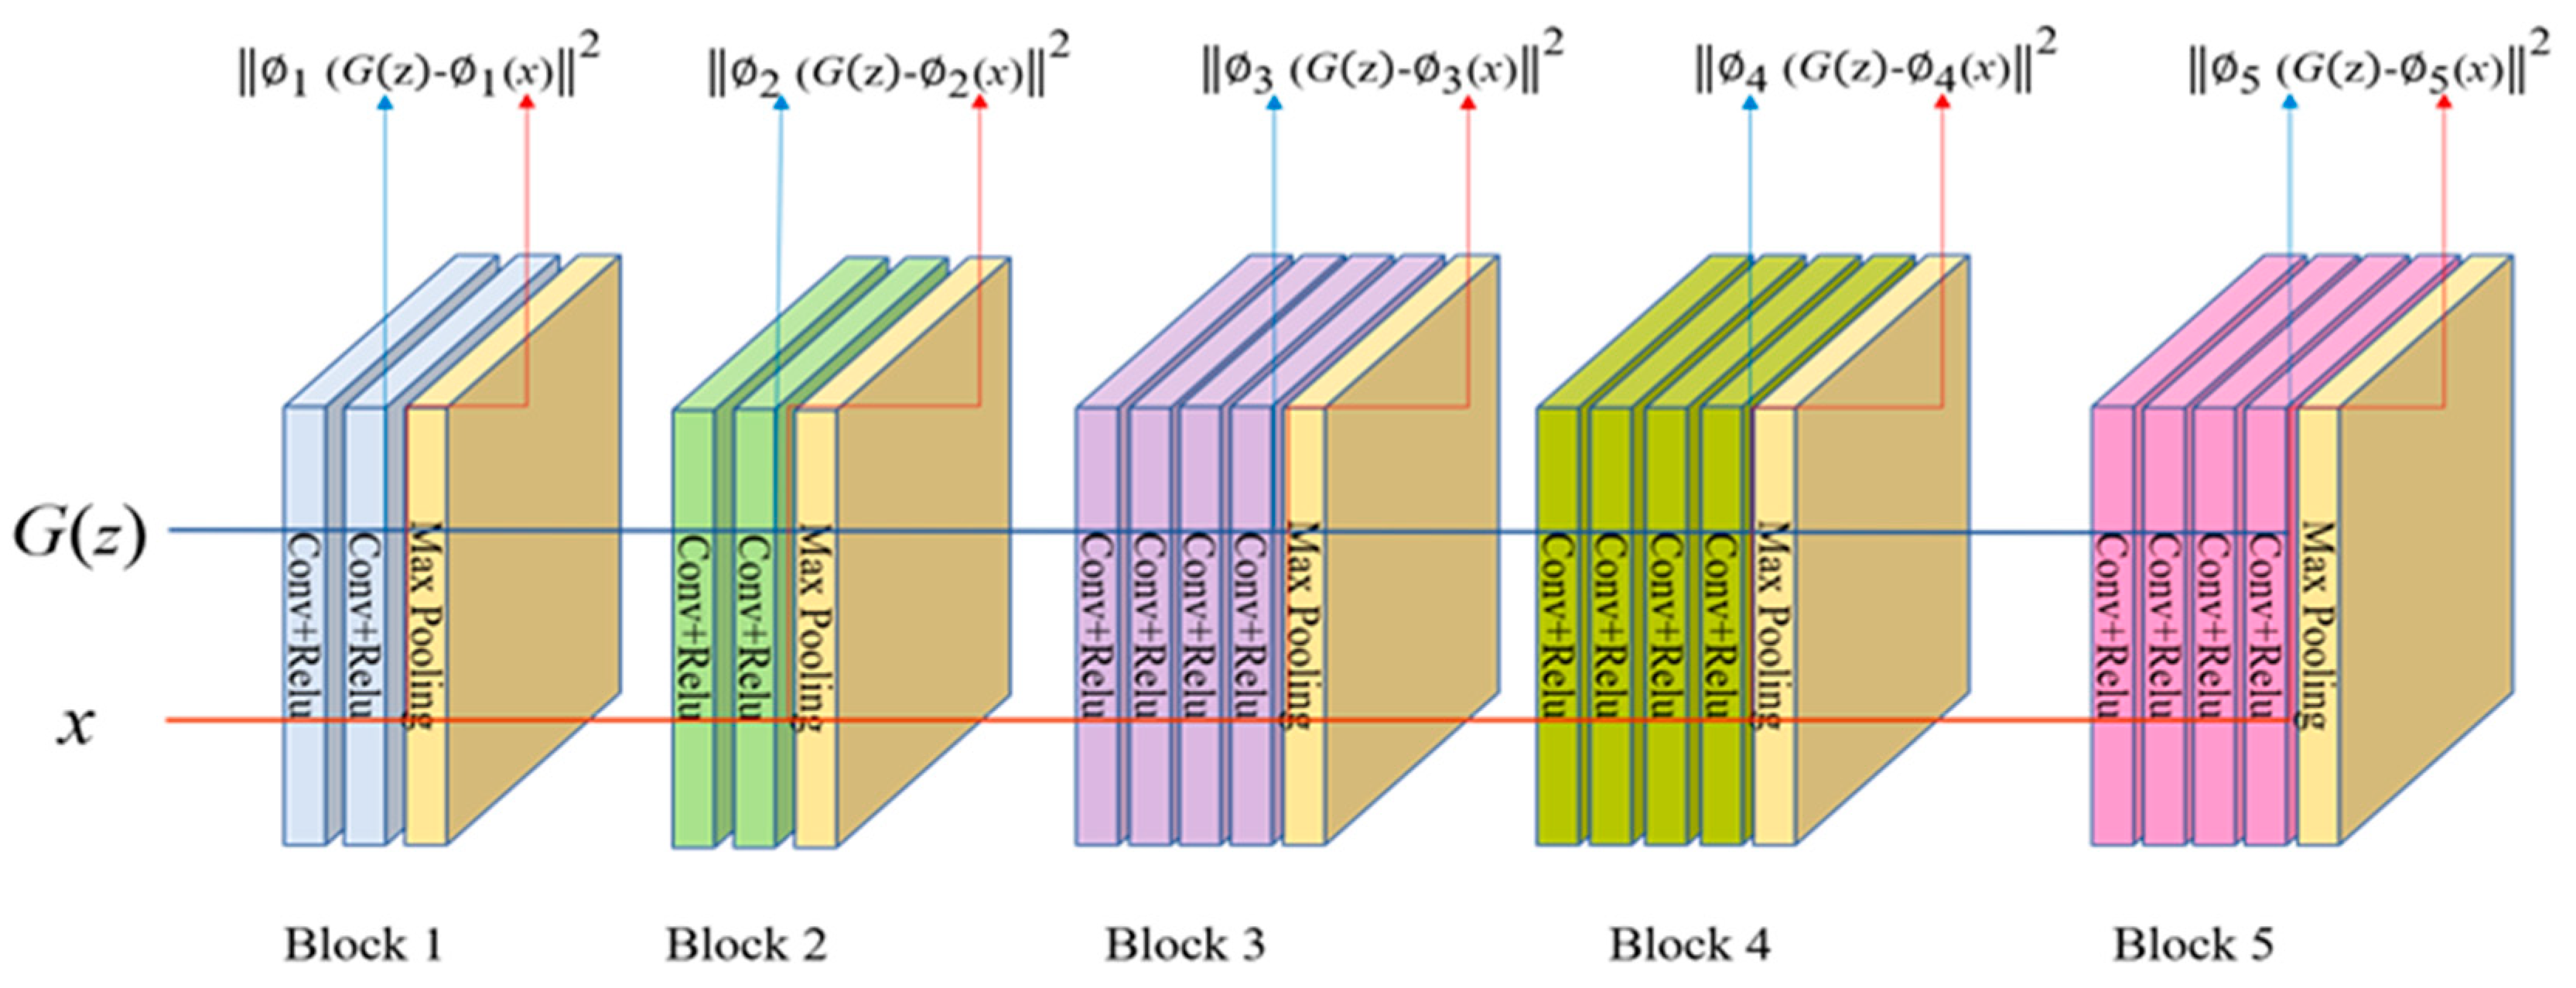

In [ ]:
import torch
import torch.nn as nn

from Losses.Loss_Base import Loss_Base
from Losses.Loss_MAE import Loss_MAE
from Config.Config import TensorType

from collections import namedtuple
from typing import List

from torchvision import transforms
from torchvision.models import vgg16, vgg19


class PerceptualLoss_VGG(Loss_Base):

    models = {"vgg16": vgg16, "vgg19": vgg19}

    def __init__(
        self,
        criterion: Loss_Base = None,
        normalizeInput: bool = False,
        reduction: str = "mean",
    ):
        super().__init__("PerceptualLoss_VGG")
        self.reduction = reduction
        self.criterion = criterion
        self.normalize = lambda x: x
        if normalizeInput:
            self.normalize = transforms.Normalize(
                mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
            )
        # self.weights = [1.0/32, 1.0/16, 1.0/8, 1.0/4, 1.0] #TODO, rethink weights -> how important specified layer is by pre-defined weights

        if self.criterion is None:
            self.criterion = Loss_MAE(reduction)

        # VGG19 network
        blocksSlice = [
            slice(0, 4),
            slice(5, 9),
            slice(10, 18),
            slice(19, 27),
            slice(28, 36),
        ]

        # Get vgg model and turn on eval mode
        vggModel = vgg19(pretrained=True).eval()
        modelFeatures = vggModel.features

        # Assign features (specified layers) from VGG19 to self
        self.model = torch.nn.ModuleList(
           [modelFeatures[slice] for slice in blocksSlice]
        )

        # Turn off requires_grad for parameters in VGG19 blocks
        for param in self.model.parameters():
            param.requires_grad = False

    def forward(
        self, srPred: TensorType = None, hrTarget: TensorType = None
    ) -> TensorType:
        assert srPred is not None, "Input tensor pred can't be None!"
        assert hrTarget is not None, "Input tensor target can't be None!"

        loss = torch.tensor(
        [0.0], dtype=torch.float32, device=srPred.device, requires_grad=True
        )  # loss will not work if reduction != mean
        for feature in self.model:
            #if idx == 3: break #lets calculate vgg loss on first 3 layers (no available GPU Memory for deeper layers)
            srPred = feature(srPred)
            with torch.no_grad():
                hrTarget = feature(hrTarget)
            loss = loss + self.criterion(srPred, hrTarget)
        return loss

In [ ]:
from typing import Dict, Union, Any
from pathlib import Path
from tqdm import tqdm  # For nice progress bar when training the data!
from datetime import date

# Own imports
from Config.Config import PathType, CurrentDevice
from Config.DefaultConfigs import (
    ModelHyperparameters,
    ConfigMapping,
    initObjectFromConfig,
)
from NeuralNetworks.NN_Base import Model_Base
from Dataset.Dataset_UE import save_exr, Dataset_UE, FullDataset_UE
from Colorspace.PreProcessing import preprocessing_pipeline, depreprocessing_pipeline
from Utils.Utils import save_model, load_model

# Libs imports
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import numpy as np

# Turn on cudnn backend and benchmark for better performance
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True


def save_checkpoint(
    model_save_path: PathType = None,
    model_name: str = None,
    epoch: int = 0,
    model: Model_Base = None,
    hyperparams: ModelHyperparameters = None,
    optimizer: optim = None,
):

    model_save_path = model_save_path / (model_name + ".pth")
    save_model(
        model_save_path,
        {
            "epoch": epoch,
            "batch_size": hyperparams.batch_size,
            "lr": hyperparams.learning_rate,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
        },
    )


# summarize history for loss
import matplotlib.pyplot as plt


def plot_loss_valid(train_loss: list = None, valid_loss: list = None, epochs: int = 10):
    assert train_loss is not None and valid_loss is not None
    epochs_list = range(0, epochs)
    max_plot_value = (
        max(train_loss) if max(train_loss) > max(valid_loss) else max(valid_loss)
    )

    fig, ax = plt.subplots(figsize=(20, 6))
    plt.title("Training and validation loss")
    plt.ylim(0.0, max_plot_value + 0.1)

    plt.plot(epochs_list, train_loss, "-", label="Training loss")
    plt.plot(epochs_list, valid_loss, "-", label="Validation loss")

    plt.ylabel("loss")
    plt.xlabel("epoch")

    # plt.xticks(range(0, epochs, int(epochs/10)))
    # plt.xticks(range(0, epochs, 1))
    plt.yticks(np.linspace(0.0, max_plot_value + 0.1, num=10))

    fig.tight_layout()
    plt.legend(["train", "valid"], loc="upper right")
    plt.show()


def training_pipeline(
    config: ConfigMapping = None, training: bool = True, model_load: bool = False
) -> Model_Base:
    """
    Training pipeline
    """
    # Init of Hyperparams, dataset, dataloader, model etc.
    hyperparams = config["hyperparameters"]["className"](
        **config["hyperparameters"]["args"]
    )
    train_ds = config["trainDS"]["className"](**config["trainDS"]["args"])
    valid_ds = config["validDS"]["className"](**config["validDS"]["args"])
    train_loader = initObjectFromConfig(
        config["trainDL"]["className"], train_ds, **config["trainDL"]["args"]
    )
    valid_loader = initObjectFromConfig(
        config["validDL"]["className"], valid_ds, **config["validDL"]["args"]
    )
    model = config["model"]["className"](**config["model"]["args"])
    criterion = config["criterion"]["className"](**config["criterion"]["args"])
    optimizer = initObjectFromConfig(
        config["optimizer"]["className"],
        model.parameters(),
        **config["optimizer"]["args"]
    )
    device = config["device"]
    dtype = config["dtype"]

    model.to(device=device, dtype=dtype)

    # If training is False, then just return model | TODO, rethink that
    if not training:
        return model

    # Load checkpoint
    if model_load:
        loaded_training_state_dict = load_model(config["model_load_path"])
        model.load_state_dict(loaded_training_state_dict["model_state_dict"])
        optimizer.load_state_dict(loaded_training_state_dict["optimizer_state_dict"])

    # Train Network
    avg_train_loss_per_epoch = []
    avg_valid_loss_per_epoch = []
    min_valid_loss = 9999.9  # kind of "max" value of valid loss to find minimal valid loss of specified training
    for epoch in range(hyperparams.num_epochs):

        # Log pass
        print("Epoch: %03d" % (epoch + 1), end="\n")

        #####################
        # Training Pipeline #
        #####################
        total_train_loss = 0.0
        model.train()  # prepare model for training
        for batch_idx, (data, target) in enumerate(tqdm(train_loader)):

            # Zeroing gradients
            optimizer.zero_grad()

            # Get data to cuda if possible
            data = data.to(device=device, dtype=dtype)
            target = target.to(device=device, dtype=dtype)

            # PreProcess the data
            data = preprocessing_pipeline(data)
            target = preprocessing_pipeline(target)

            # forward
            pred = model(data)
            loss = criterion(pred, target)

            # accumulate loss, loss * amount N batch size
            total_train_loss += loss.item() * data.size(0)

            # loss backward and optimizer
            loss.backward()
            optimizer.step()

        #######################
        # Validating Pipeline #
        #######################
        total_valid_loss = 0.0
        model.eval()  # prepare model for validation
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(tqdm(valid_loader)):

                # Get data to cuda if possible
                data = data.to(device=device, dtype=dtype)
                target = target.to(device=device, dtype=dtype)

                # PreProcess the data
                data = preprocessing_pipeline(data)
                target = preprocessing_pipeline(target)

                # forward
                pred = model(data)
                loss = criterion(pred, target)

                # accumulate loss, loss * amount N batch size
                total_valid_loss += loss.item() * data.size(0)

        # divide avg train/valid loss by length of data loader
        # it will give a correct avg loss
        # if divided by batch_size, then sometimes it may be not correct,
        # because batch_size is sometimes not dividable by num of samples
        total_train_loss = total_train_loss / len(train_loader)
        total_valid_loss = total_valid_loss / len(valid_loader)
        avg_train_loss_per_epoch.append(total_train_loss)
        avg_valid_loss_per_epoch.append(total_valid_loss)

        # Model's Checkpoint saving
        if min_valid_loss > total_valid_loss:
            min_valid_loss = total_valid_loss
            save_checkpoint(
                config["model_save_path"],
                "model_float32_best",
                epoch,
                model,
                hyperparams,
                optimizer,
            )
            print(
                "Checkpoint saved at {} epoch with {:.4f} total valid loss".format(
                    epoch, total_valid_loss
                )
            )

        # Log pass
        print()
        print(" Total train loss: %.4f" % total_train_loss, end="\n")
        print(" Total valid loss: %.4f" % total_valid_loss, end="\n")
        print()

    # Plot train and valid loss at n epochs
    plot_loss_valid(
        avg_train_loss_per_epoch, avg_valid_loss_per_epoch, hyperparams.num_epochs
    )

    # Save model's checkpoint
    save_checkpoint(
        config["model_save_path"],
        "model_float32_final",
        hyperparams.num_epochs,
        model,
        hyperparams,
        optimizer,
    )

    return model

In [ ]:
config = initConfig()
config

In [ ]:
from datetime import datetime

start_time = datetime.now()

trained_model = training_pipeline(
    config, training=config["run_training"], model_load=config["load_model"]
)

time_elapsed = datetime.now() - start_time

print("\nTraining Time elapsed (hh:mm:ss.ms) {}".format(time_elapsed))